In [9]:
from random import shuffle, randint, uniform
from datetime import datetime
import pandas as pd
import numpy as np
import pickle
import math
from sklearn.model_selection import train_test_split, KFold, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from operator import itemgetter
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
#%matplotlib inline
import gc
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [10]:
#####wczytanie danych
df=pd.read_excel('data.xlsx', sheet_name='Scalanie1')

In [3]:
#wstepne ograniczenie zbioru
df=df[df.kategoria=='malarstwo i rysunek'].reset_index(drop=True)
df=df[(df.departament=='Młoda Sztuka')|(df.departament=='Sztuka Dawna')|(df.departament=='Sztuka Współczesna')|(df.departament=='Komiks i Ilustracja')|(df.departament=='Sztuka Najnowsza')].reset_index(drop=True)
df=df.dropna(subset=['cena']).reset_index(drop=True)

In [4]:
#transformacja zmiennych
#tryb aukcji
df['live']=[1 if i=='live' else 0 for i in df.tryb]
df['online']=[1 if i=='online' else 0 for i in df.tryb]
df['hybrid']=[1 if i=='hybrid' else 0 for i in df.tryb]
#departament
df['mloda_sztuka']=[1 if i=='Młoda Sztuka' else 0 for i in df.departament]
df['sztuka_dawna']=[1 if i=='Sztuka Dawna' else 0 for i in df.departament]
df['sztuka_wspolczesna']=[1 if i=='Sztuka Współczesna' else 0 for i in df.departament]
df['komiksy']=[1 if i=='Komiks i Ilustracja' else 0 for i in df.departament]
df['sztuka_najnowsza']=[1 if i=='Sztuka Najnowsza' else 0 for i in df.departament]
#df['aukcje_tematyczne']=[1 if i=='Aukcje Tematyczne' else 0 for i in df.departament]
#df['aukcje_charytatywne']=[1 if i=='Aukcje Charytatywne' else 0 for i in df.departament]
#df['rzezba']=[1 if i=='Rzeźba' else 0 for i in df.departament]
#df['design_i_wzornictwo']=[1 if i=='Design i Wzornictwo Artystyczne' else 0 for i in df.departament]
#df['rzemiosło_artystyczne']=[1 if i=='Rzemiosło Artystyczne' else 0 for i in df.departament]
#df['fotografia']=[1 if i=='Fotografia' else 0 for i in df.departament]
#df['memorabilia']=[1 if i=='Memorabilia' else 0 for i in df.departament]
#df['plakat']=[1 if i=='Plakat' else 0 for i in df.departament]
#df['biżuteria']=[1 if i=='Biżuteria kolekcjonerska' else 0 for i in df.departament]
#df['zegarki']=[1 if i=='Zegarki' else 0 for i in df.departament]
#df['aukcje_kolekcji']=[1 if i=='Aukcje Kolekcji' else 0 for i in df.departament]

In [5]:
def extract_age(text):
    if isinstance(text, str):  # check if variable is string
        return text.rsplit('(', 1)[-1][:-1]
    else:
        return 'NaN'
        
def birth(text):
    if extract_age(text)!='NaN':
        if len(extract_age(text))==4:
            return extract_age(text)
        else:
            return extract_age(text)[:4]
    else:
        return 'NaN'

def died(text):
    if extract_age(text)!='NaN':
        if len(extract_age(text))==4:
            return 'no'
        else:
            return extract_age(text)[-4:]
    else:
        return 'NaN'

df['born']=pd.to_numeric(df['autor'].apply(birth), errors='coerce')
df['died']=df['autor'].apply(died)
df['age']=pd.to_numeric(df.died.replace('no', datetime.now().year), errors='coerce')-pd.to_numeric(df.born, errors='coerce')
df['alive']=[1 if i=='no' else 0 for i in df.died]

In [6]:
def name(text):
    if isinstance(text, str):  # check if variable is string
        index = text.rfind('(')
        if index != -1:
            return text[:index-1]
        else:
            return text
    else:
        return text
df['name']=df['autor'].apply(name)

In [7]:
def if_woman(text):
    if isinstance(text, str):  # check if variable is string
        if text.split(' ')[0][-1]=='a':
            return 1
        else:
            return 0
    return "NaN"
df['woman']=pd.to_numeric(df['name'].apply(if_woman), errors='coerce')

In [8]:
df['rok_wykonania']=pd.to_numeric(df.tytul.str.split().str[-1], errors='coerce')

In [9]:
# Funkcja do obliczania pola prostokąta
def oblicz_pole(wymiary):
    try:
        if isinstance(wymiary, float):
            return 'NaN'
        elif not wymiary[0].isdigit():
            return 'NaN'
        elif len(wymiary.split('x'))>3:
            return 'NaN'
        elif len(wymiary)<=4:
            return 'NaN'
        elif '[x' in wymiary:
            ile = pd.to_numeric(wymiary.split('[x')[1][0])
            szerokosc, wysokosc = map(float, wymiary.split('[x')[0].replace('cm', '').replace(',', '.').split('x'))
            return szerokosc * wysokosc * ile
        elif '(x' in wymiary:
            ile = pd.to_numeric(wymiary.split('(x')[1][0])
            szerokosc, wysokosc = map(float, wymiary.split('(x')[0].replace('cm', '').replace(',', '.').split('x'))
            return szerokosc * wysokosc * ile
        elif len(wymiary.split('cm'))>=3:
            return 'NaN'
        elif len(wymiary.split('x'))==3:
            dl1, dl2, dl3 = map(float, wymiary.split('cm')[0].replace(',', '.').split('x'))
            return max(dl1*dl2, dl2*dl3, dl1*dl3)
        elif 'śr.:' in wymiary:
            return (pd.to_numeric(wymiary.split('śr.:')[-1].replace(',', '.').replace('cm', ''))**2)*math.pi/4
        elif 'cm' not in wymiary:
            szerokosc, wysokosc = map(float, wymiary.split('(')[0].replace(',', '.').split('x'))
            return szerokosc * wysokosc
        else:
            szerokosc, wysokosc = map(float, wymiary.split('cm')[0].replace(',', '.').split('x'))
            return szerokosc * wysokosc
    except:
        return 'NaN'
        
df['pole']=pd.to_numeric(df['wymiary'].apply(oblicz_pole), errors='coerce')

In [10]:
def material(text):
    try:  # check if variable is string
        return text.split('/')[1]
    except:
        return 'NaN'
def farba(text):
    try:  # check if variable is string
        return text.split('/')[0]
    except:
        return 'NaN'
df['material'] = df['technika'].apply(material)
df['farba'] = df['technika'].apply(farba)

#material
df['plotno']=[1 if i=='płótno' else 0 for i in df.material]
df['papier']=[1 if i=='papier' else 0 for i in df.material]
df['tektura']=[1 if i=='tektura' else 0 for i in df.material]
df['plyta']=[1 if i=='płyta' else 0 for i in df.material]
df['deska']=[1 if i=='deska' else 0 for i in df.material]
df['inny_material']=[1 if i not in ['deska', 'płyta', 'tektura', 'papier', 'płótno'] else 0 for i in df.material]
#farba
df['olej']=[1 if i=='olej' else 0 for i in df.farba]
df['akryl']=[1 if i=='akryl' else 0 for i in df.farba]
df['tusz']=[1 if i=='tusz' else 0 for i in df.farba]
df['akwarela']=[1 if i=='akwarela' else 0 for i in df.farba]
df['ołówek']=[1 if i=='ołówek' else 0 for i in df.farba]
df['inna_farba']=[1 if i not in ['olej', 'akryl', 'tusz', 'akwarela', 'ołówek'] else 0 for i in df.farba]

In [11]:
df['galeria']=[0 if isinstance(i, float) or i=="0" else 1 for i in df.wystawiany]
df['pochodzenie']=[0 if isinstance(i, float) or i=="0" else 1 for i in df.proweniencja]
df['posiada_literature']=[0 if isinstance(i, float) or i=="0" else 1 for i in df.literatura]
df['sygnowany']=[0 if isinstance(i, float) or i=="0" else 1 for i in df.sygnatura]
df['wystawa_przedaukcyjna']=[0 if isinstance(i, float) or i=="0" else 1 for i in df.wystawa]

In [12]:
#ograniczenie zbioru
df=df[(df.data.isna()==False)&(df.age.isna()==False)&(df.rok_wykonania.isna()==False)&(df.pole!='NaN')&
(df.rok_wykonania>1600)&(df.rok_wykonania<2025)&(df.pole>1)&(df.material!="NaN")]

In [13]:
#df=df.dropna().reset_index(drop=True)
#df.to_csv('D:/Studia/WNE/Materialy/magisterka/python.csv', index = False, header=True)

In [14]:
del df['estymacja']
del df['autor']
del df['tytul']
del df['kategoria']
del df['wymiary']
del df['technika']
del df['sygnatura']
del df['opis_przedmiotu']
del df['proweniencja']
del df['literatura']
del df['wystawiany']
del df['link_przedmiotu']
del df['nazwa_aukcji']
del df['kod_aukcji']
del df['name']
del df['departament']
del df['tryb']
del df['link_aukcji']
del df['link_bid']
del df['wystawa']
del df['material']
del df['farba']
del df['died']

In [15]:
del df['lokalizacja']
del df['data']

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cena,9233.0,45402.019929,298660.527479,300.0,1800.0,4500.0,17000.0,17000000.0
katalog,9233.0,0.871656,0.334491,0.0,1.0,1.0,1.0,1.0
film_promocyjny,9233.0,0.245857,0.430618,0.0,0.0,0.0,0.0,1.0
opis_aukcji,9233.0,0.259396,0.438327,0.0,0.0,0.0,1.0,1.0
live,9233.0,0.593307,0.491243,0.0,0.0,1.0,1.0,1.0
online,9233.0,0.092819,0.290195,0.0,0.0,0.0,0.0,1.0
hybrid,9233.0,0.313874,0.464091,0.0,0.0,0.0,1.0,1.0
mloda_sztuka,9233.0,0.387956,0.487311,0.0,0.0,0.0,1.0,1.0
sztuka_dawna,9233.0,0.155312,0.362222,0.0,0.0,0.0,0.0,1.0
sztuka_wspolczesna,9233.0,0.369219,0.482620,0.0,0.0,0.0,1.0,1.0


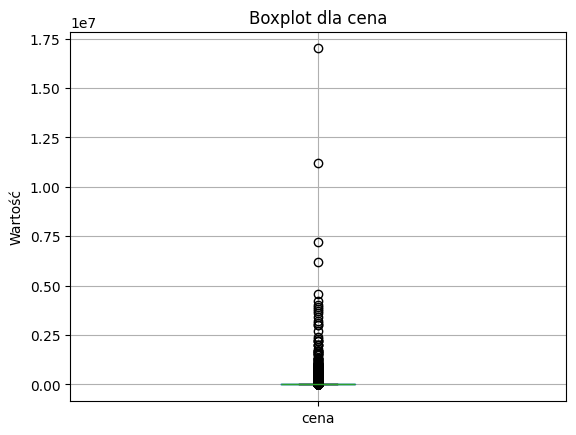

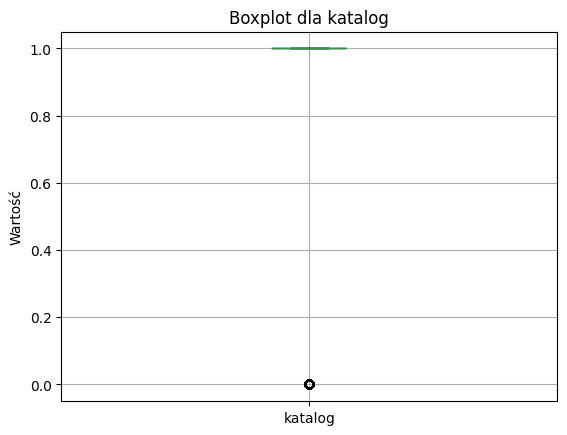

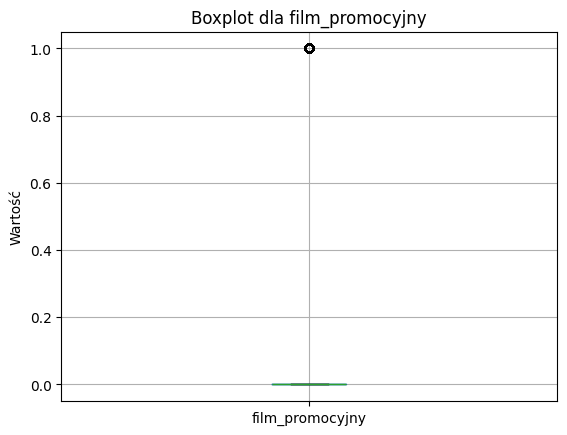

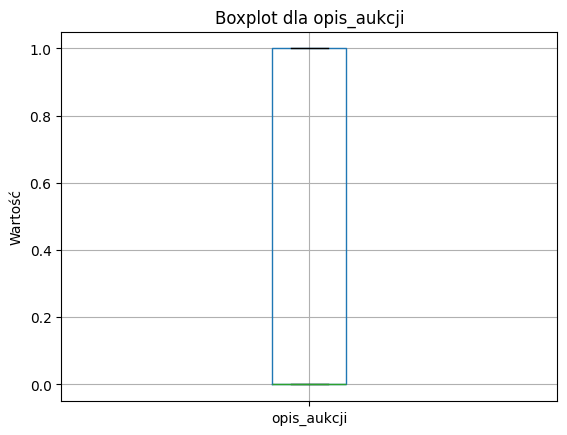

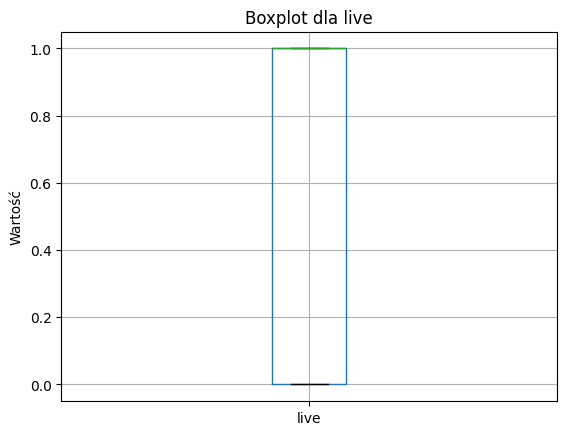

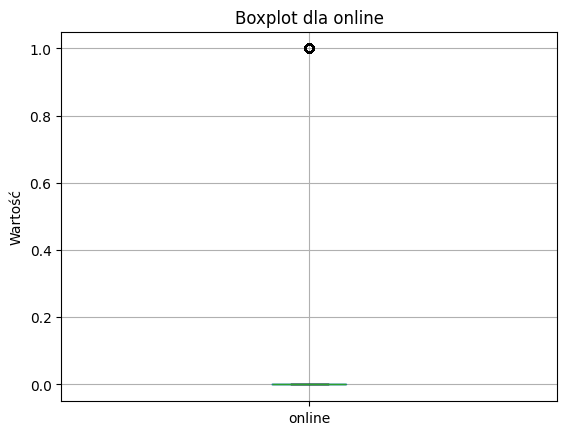

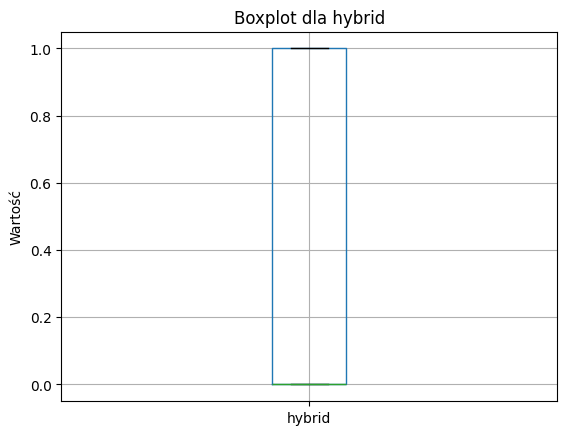

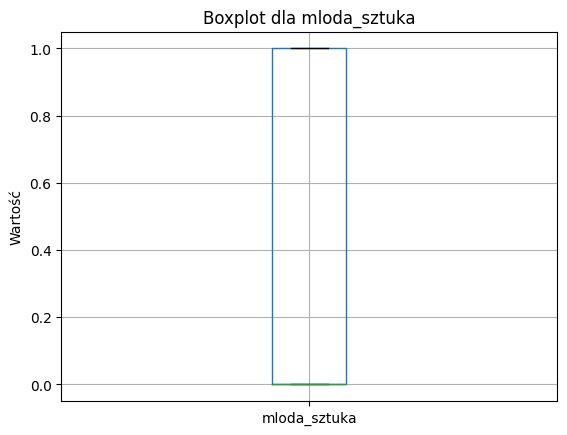

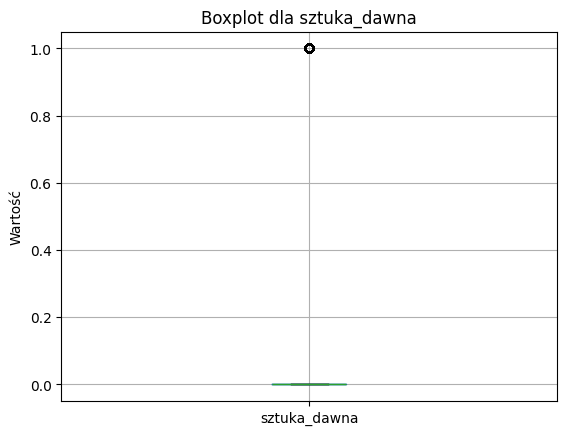

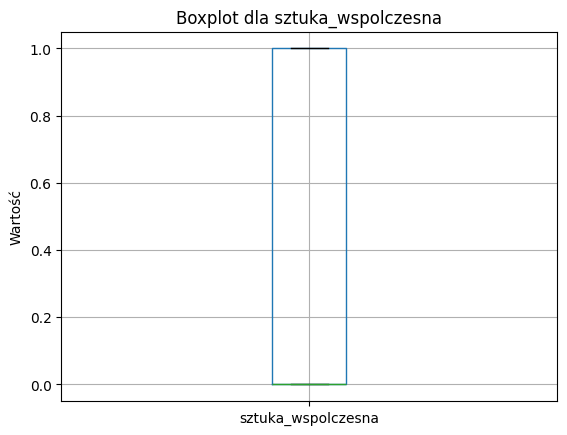

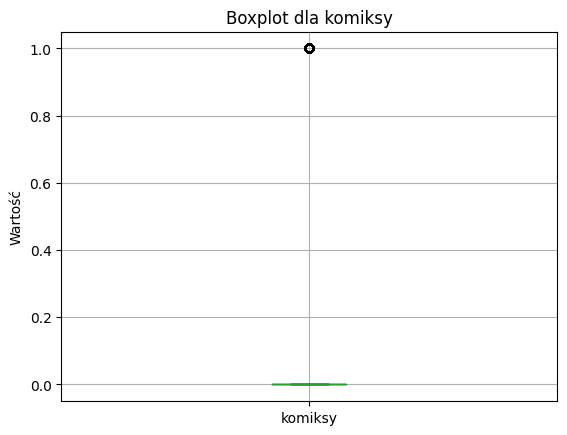

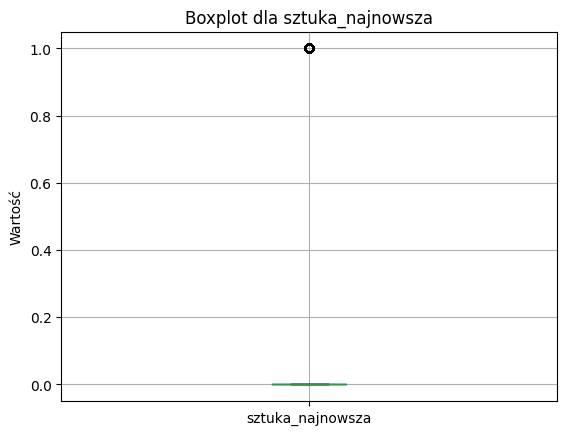

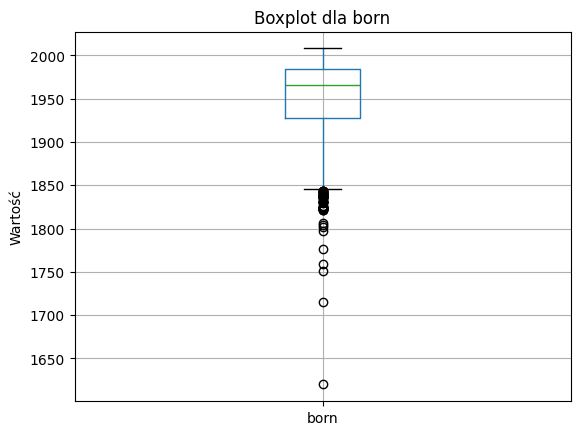

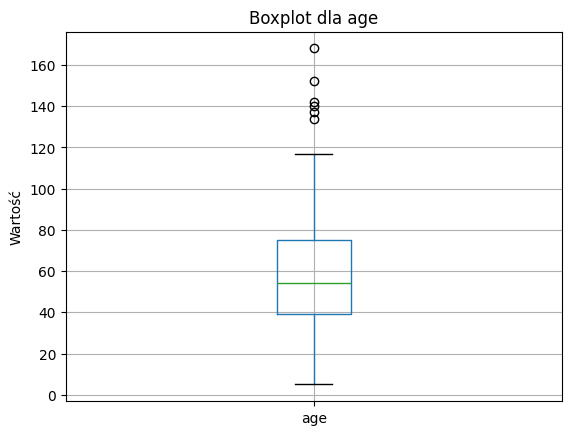

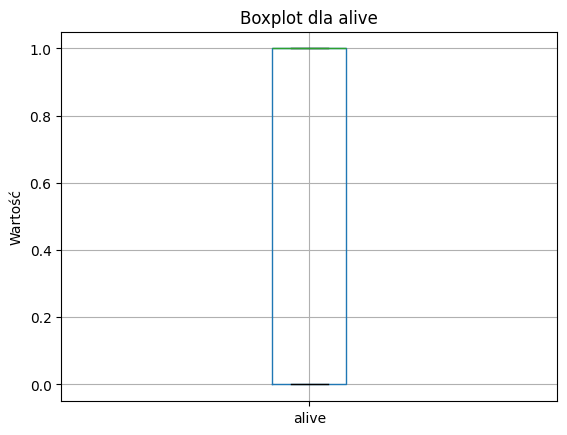

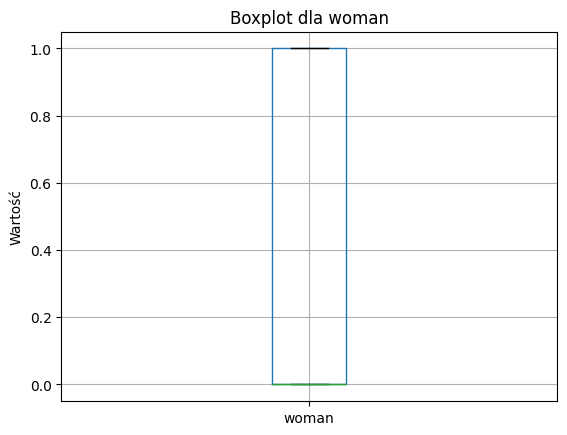

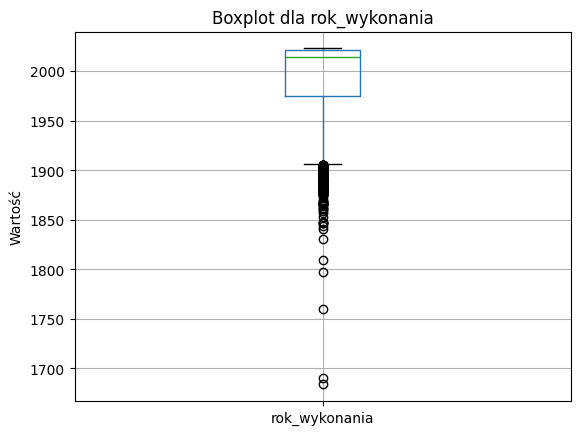

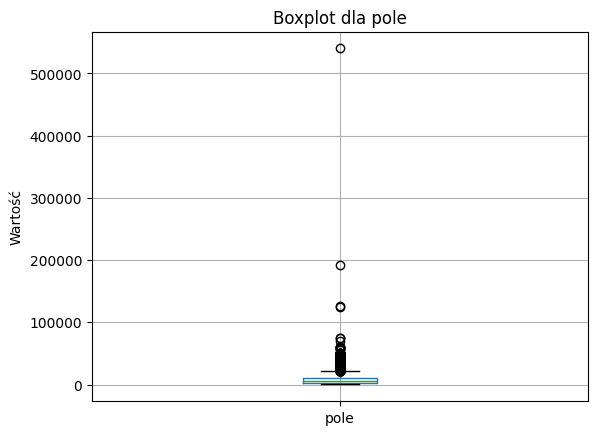

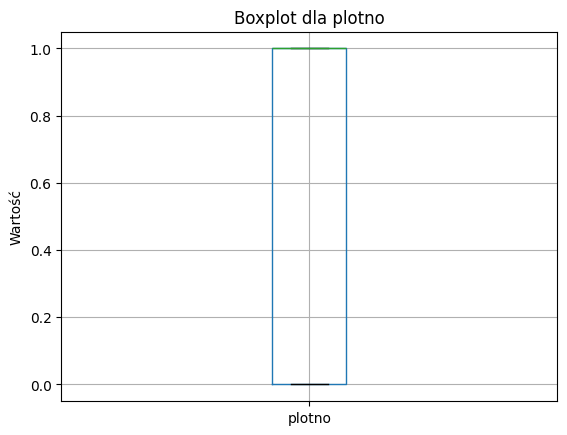

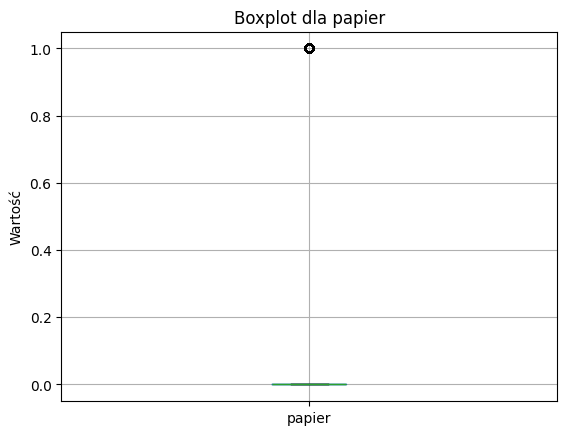

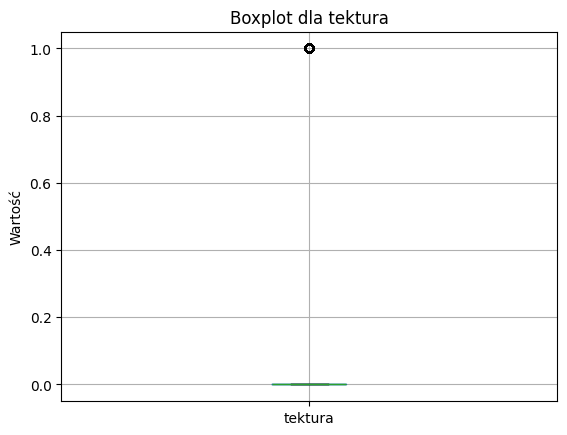

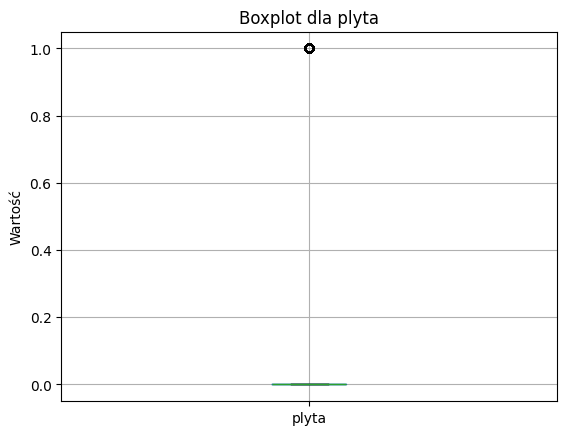

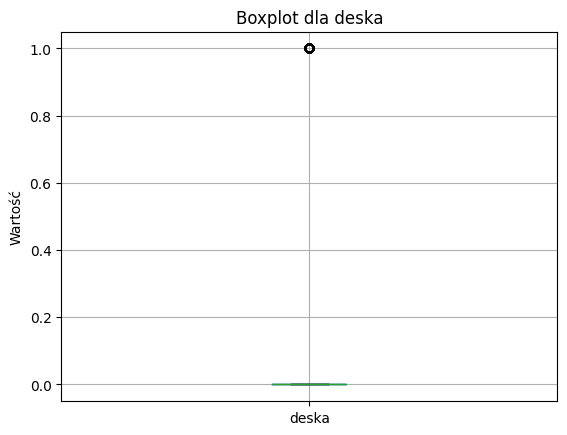

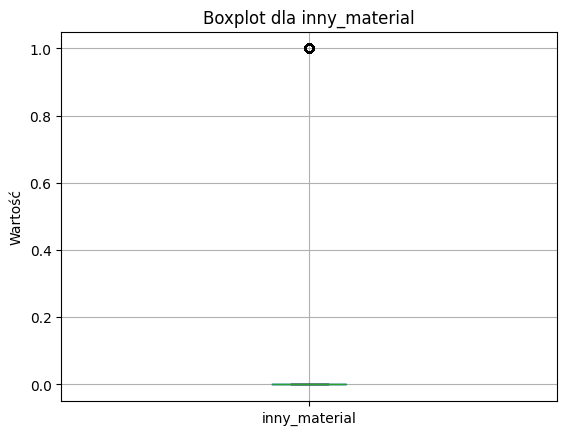

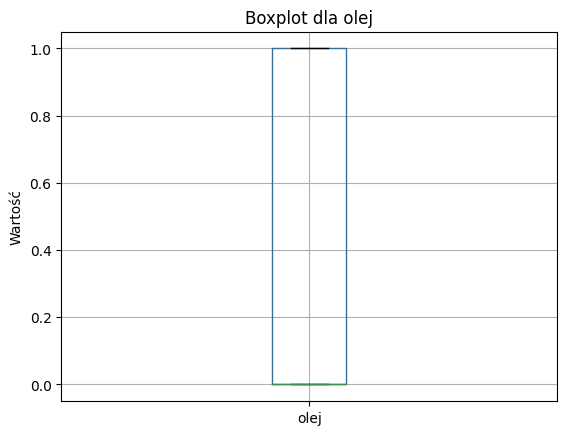

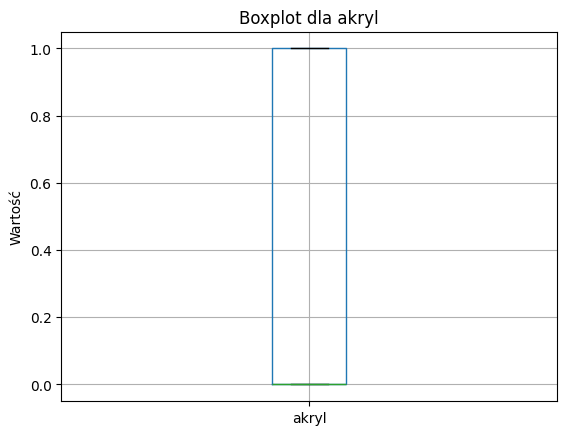

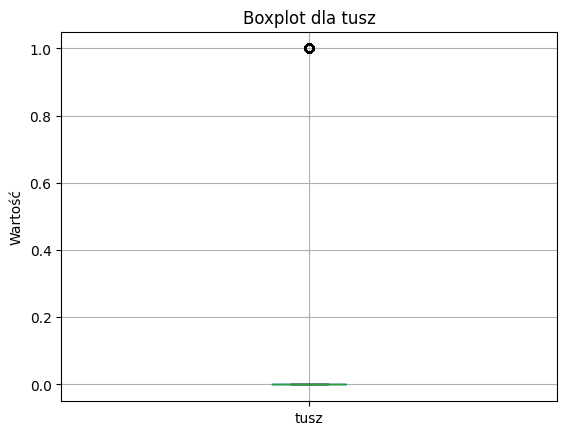

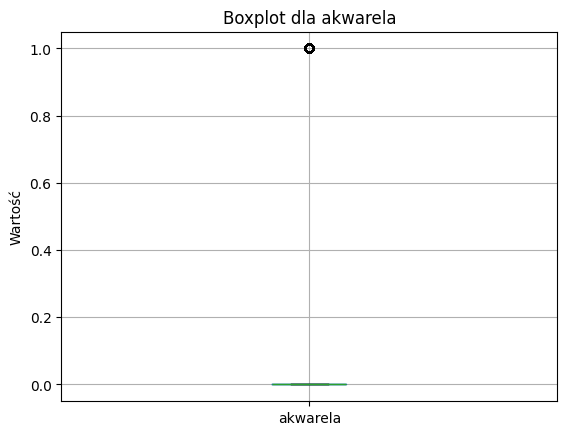

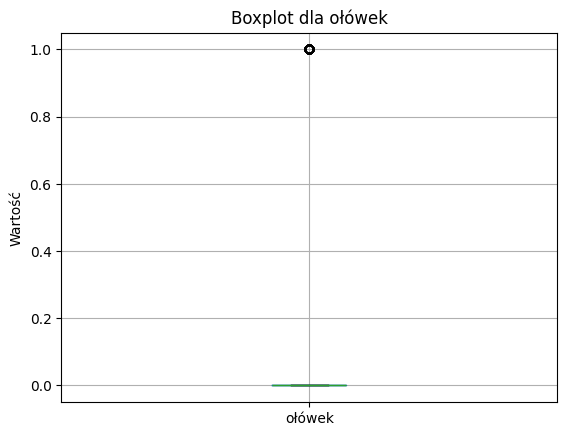

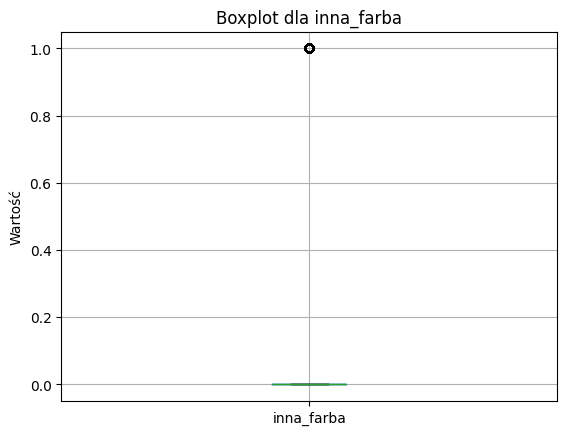

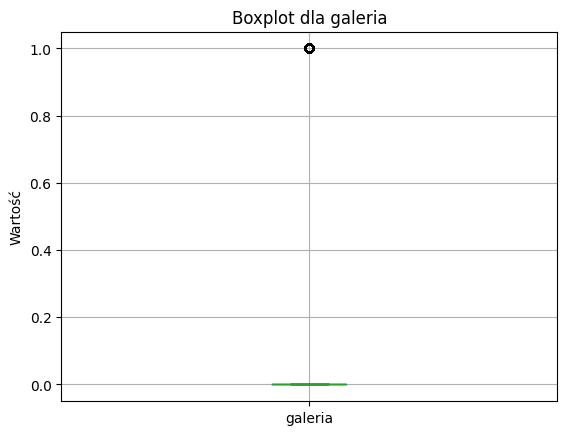

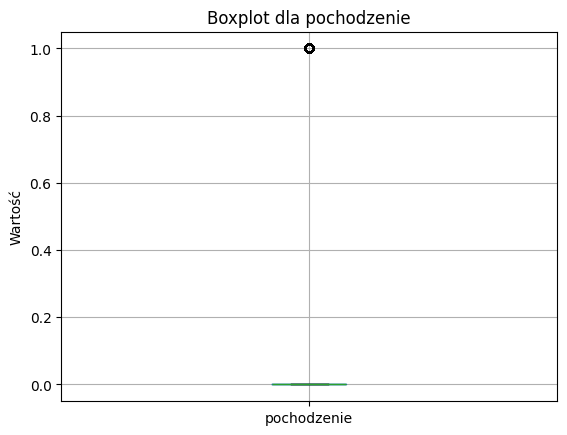

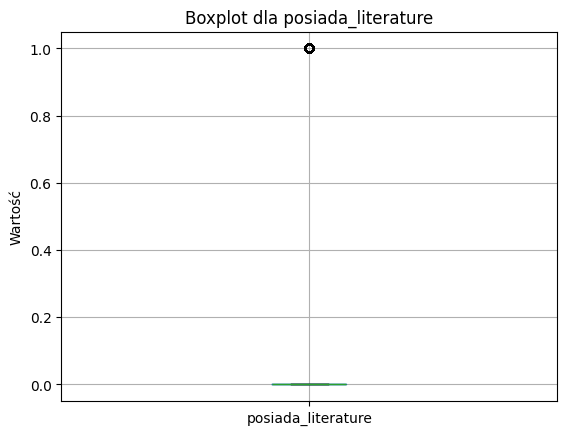

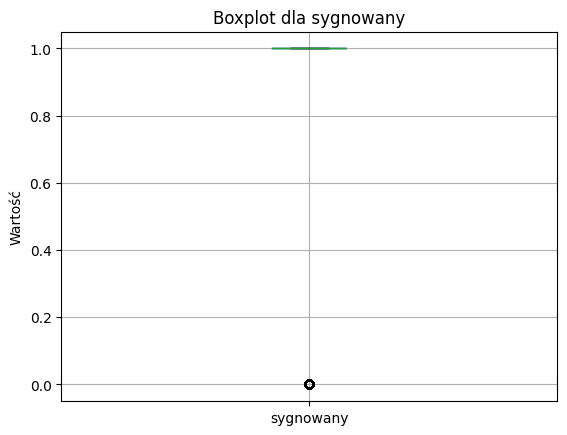

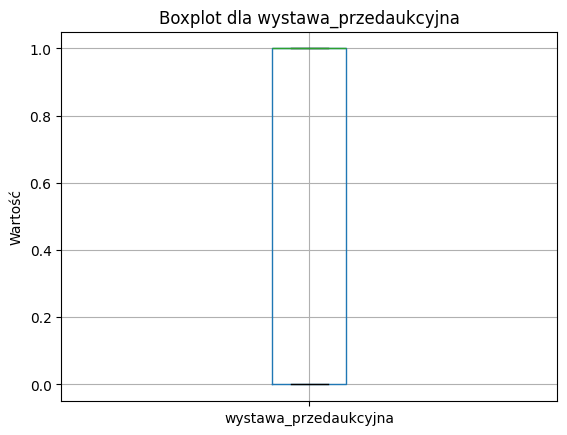

In [16]:
for column in df.select_dtypes(include='number').columns:
    plt.figure()  # Tworzy nowy wykres dla każdej zmiennej
    df.boxplot(column=[column])
    plt.title(f'Boxplot dla {column}')
    plt.ylabel('Wartość')
    plt.show()

<Figure size 640x480 with 0 Axes>

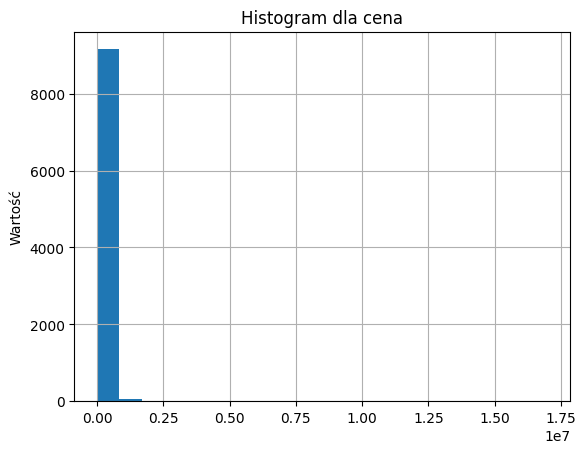

<Figure size 640x480 with 0 Axes>

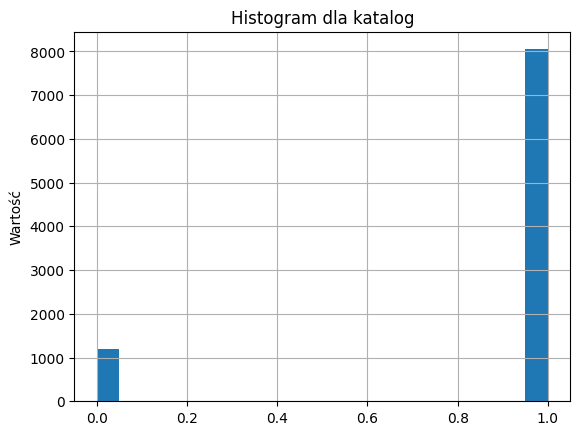

<Figure size 640x480 with 0 Axes>

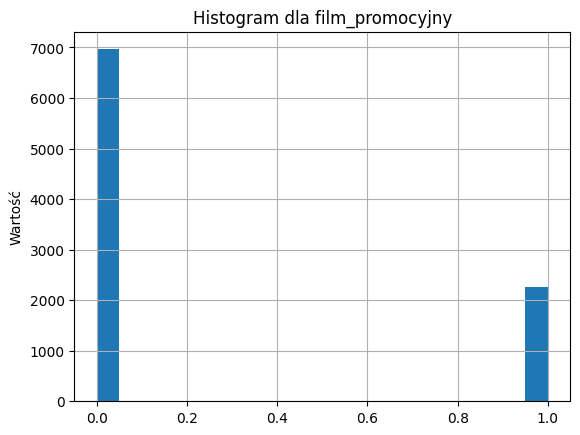

<Figure size 640x480 with 0 Axes>

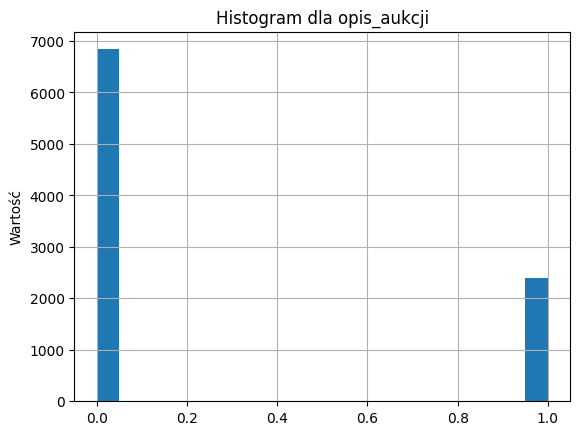

<Figure size 640x480 with 0 Axes>

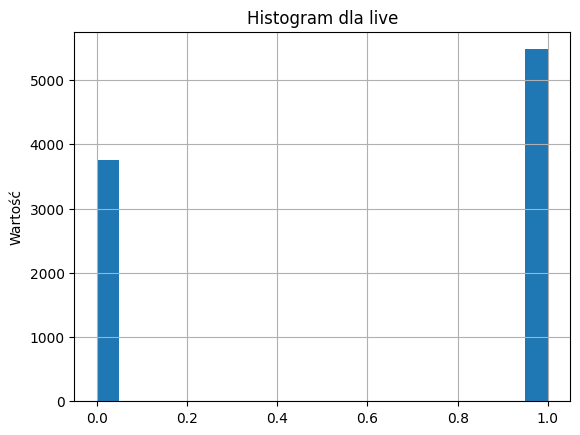

<Figure size 640x480 with 0 Axes>

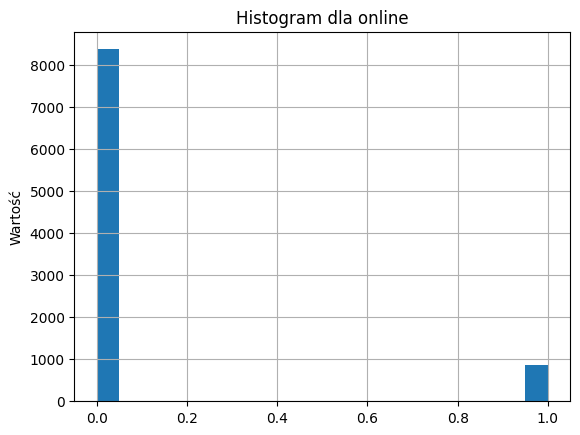

<Figure size 640x480 with 0 Axes>

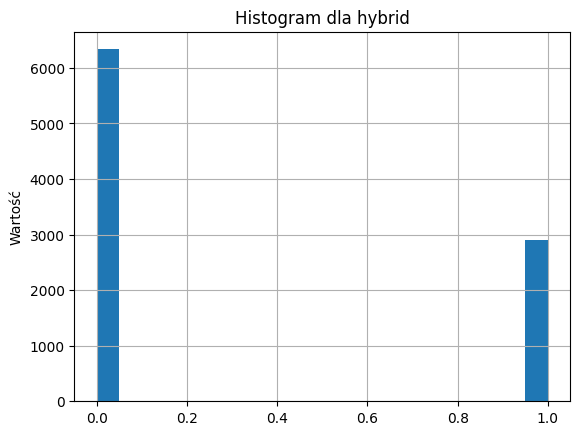

<Figure size 640x480 with 0 Axes>

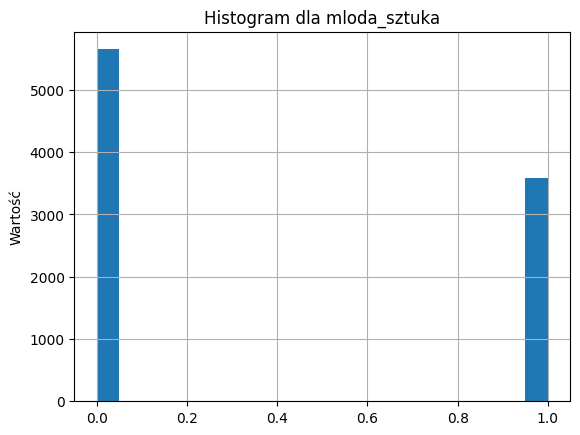

<Figure size 640x480 with 0 Axes>

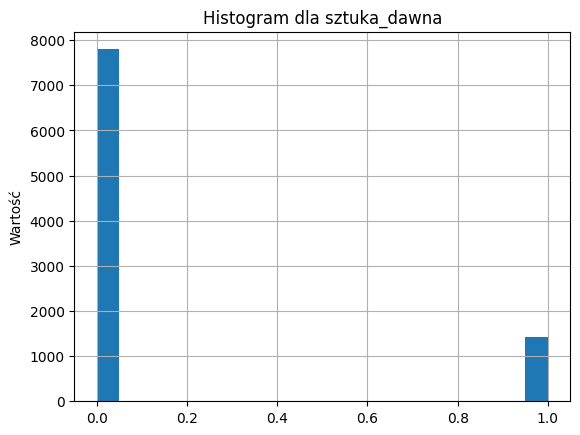

<Figure size 640x480 with 0 Axes>

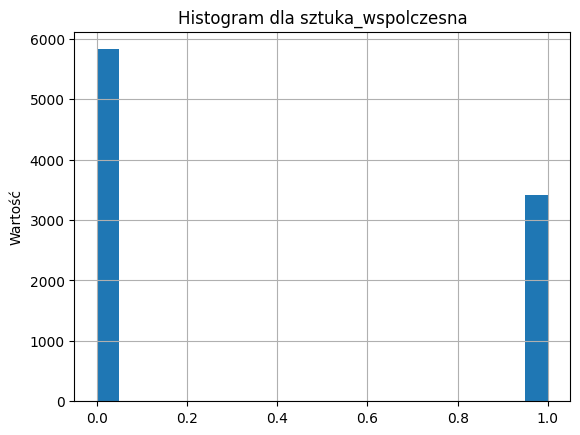

<Figure size 640x480 with 0 Axes>

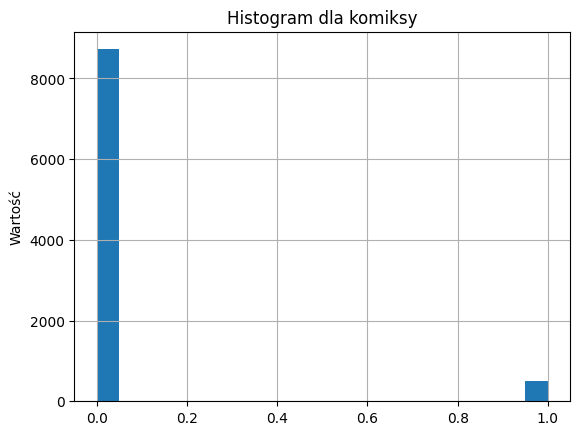

<Figure size 640x480 with 0 Axes>

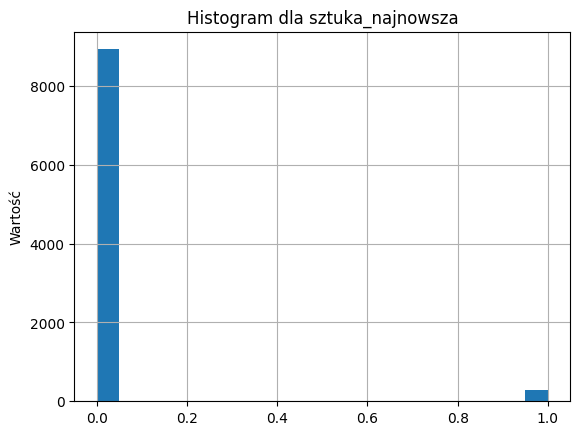

<Figure size 640x480 with 0 Axes>

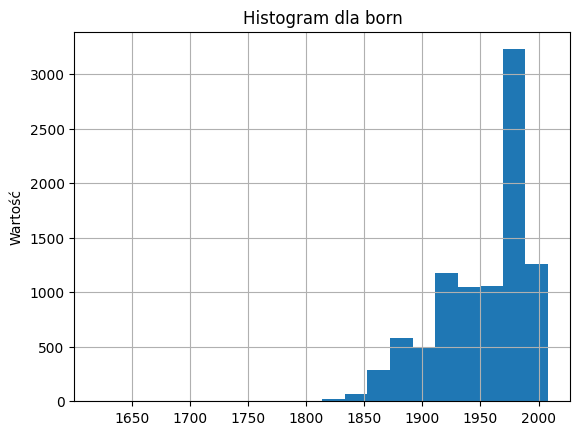

<Figure size 640x480 with 0 Axes>

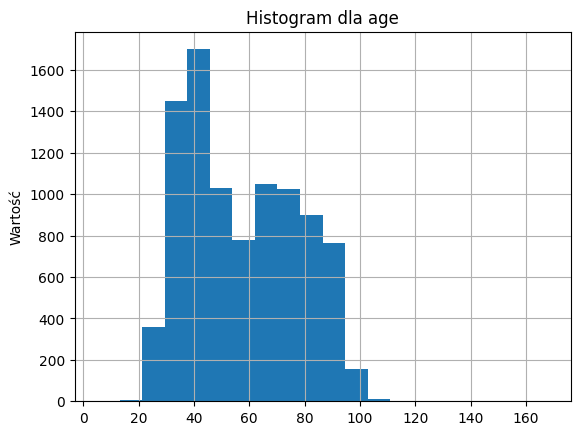

<Figure size 640x480 with 0 Axes>

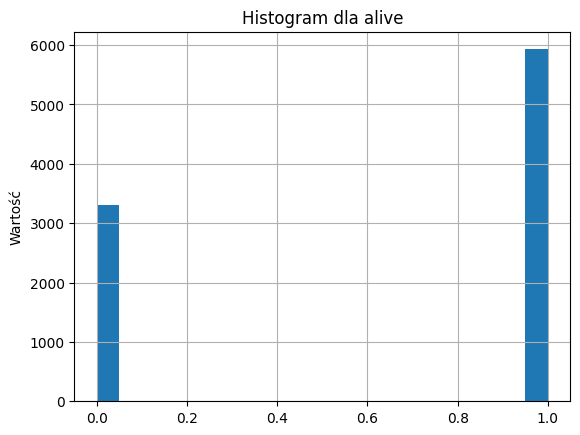

<Figure size 640x480 with 0 Axes>

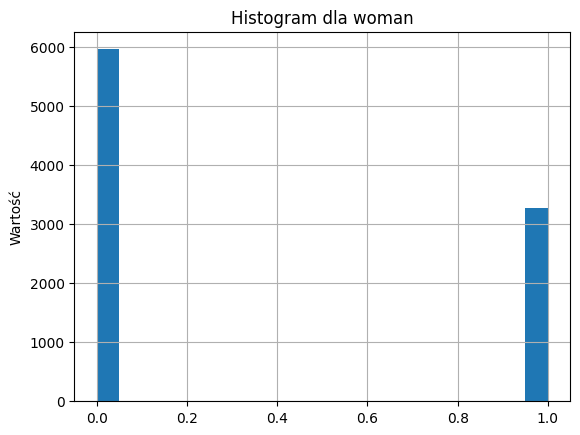

<Figure size 640x480 with 0 Axes>

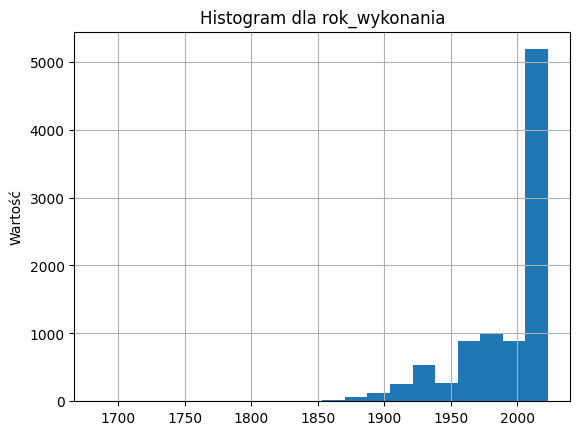

<Figure size 640x480 with 0 Axes>

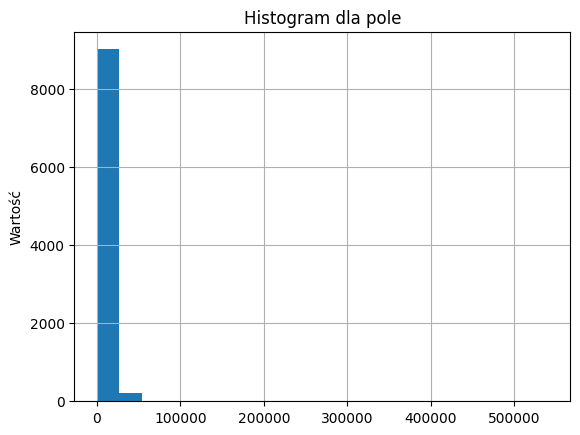

<Figure size 640x480 with 0 Axes>

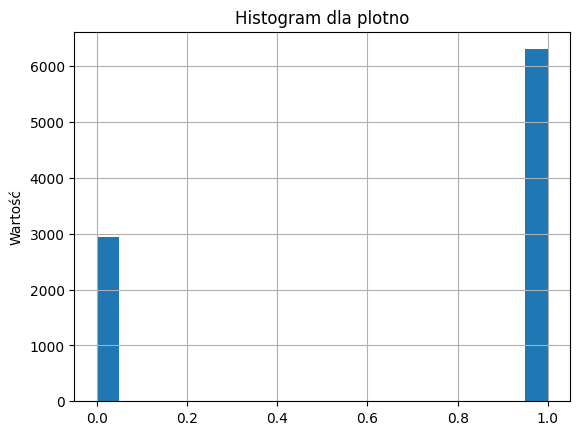

<Figure size 640x480 with 0 Axes>

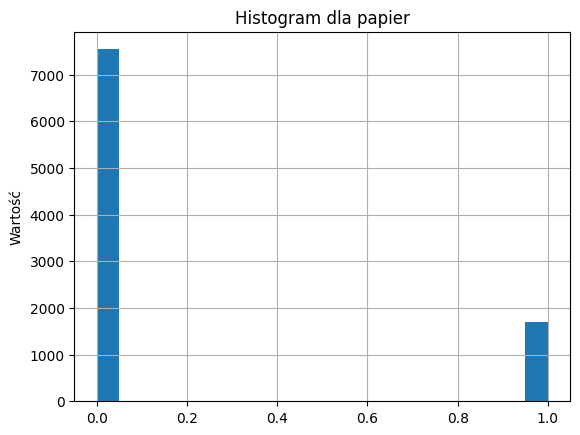

<Figure size 640x480 with 0 Axes>

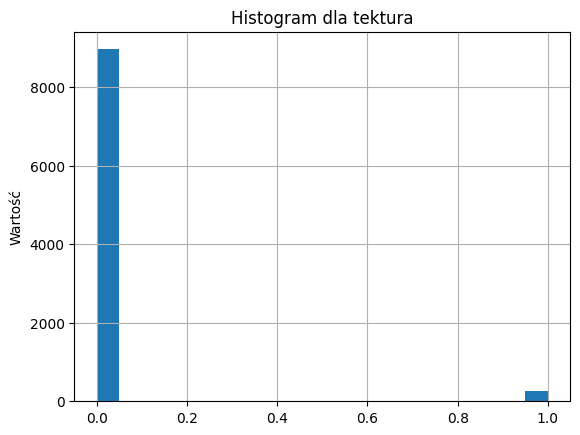

<Figure size 640x480 with 0 Axes>

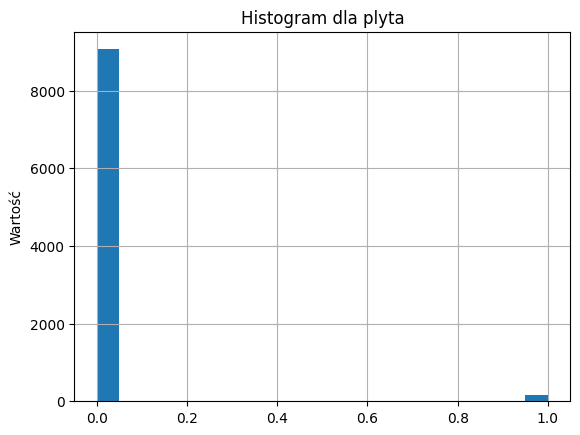

<Figure size 640x480 with 0 Axes>

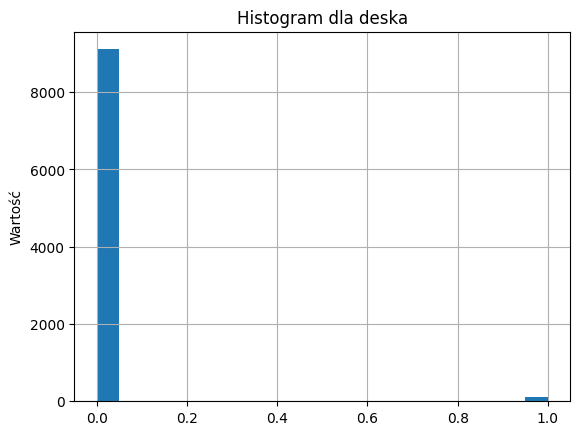

<Figure size 640x480 with 0 Axes>

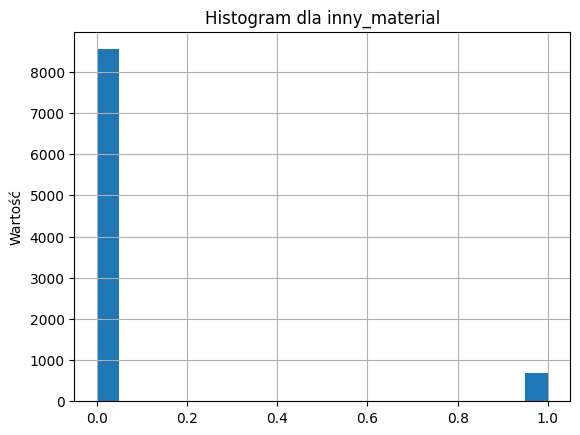

<Figure size 640x480 with 0 Axes>

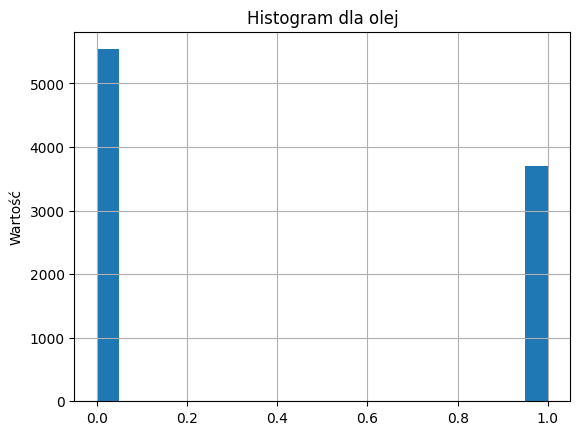

<Figure size 640x480 with 0 Axes>

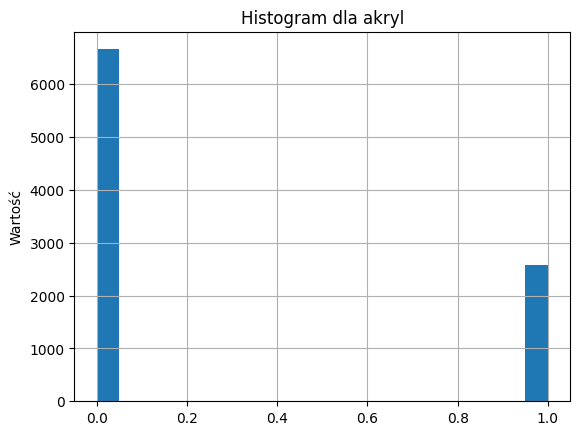

<Figure size 640x480 with 0 Axes>

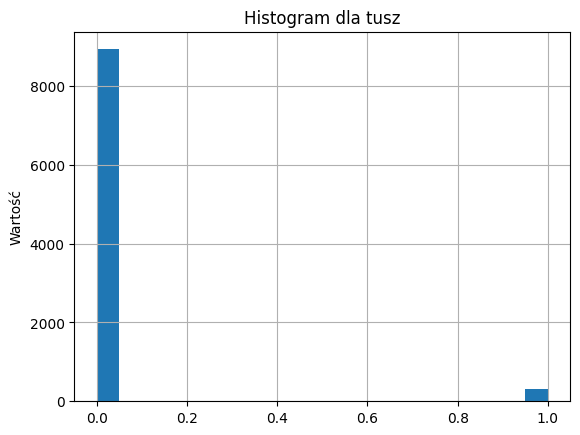

<Figure size 640x480 with 0 Axes>

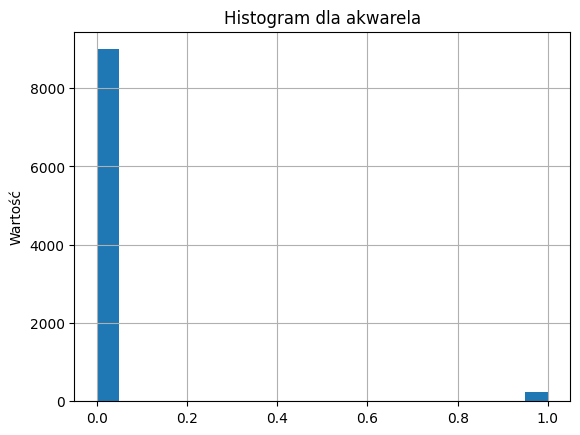

<Figure size 640x480 with 0 Axes>

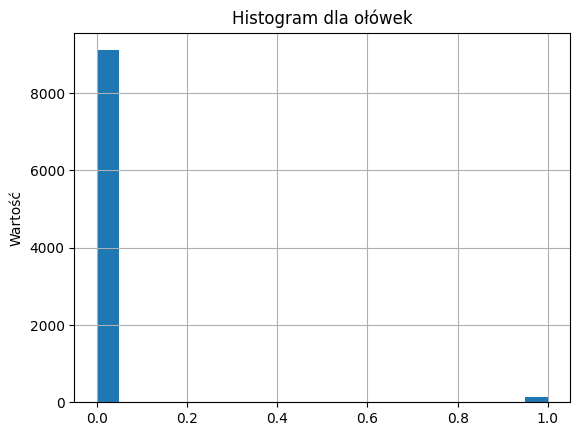

<Figure size 640x480 with 0 Axes>

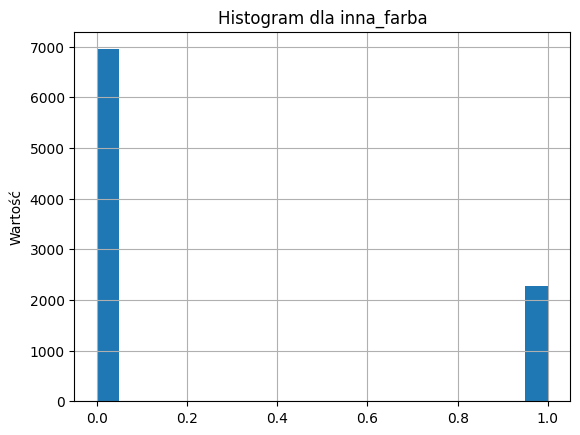

<Figure size 640x480 with 0 Axes>

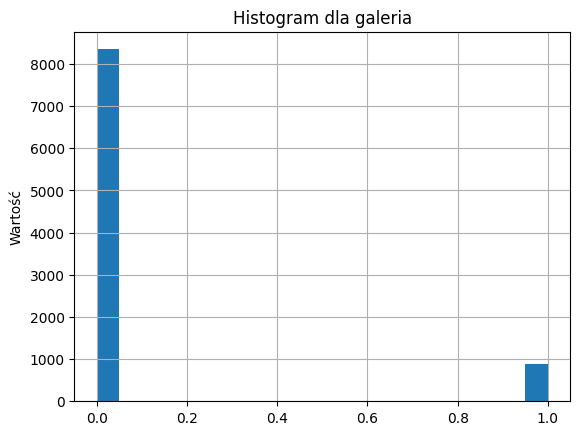

<Figure size 640x480 with 0 Axes>

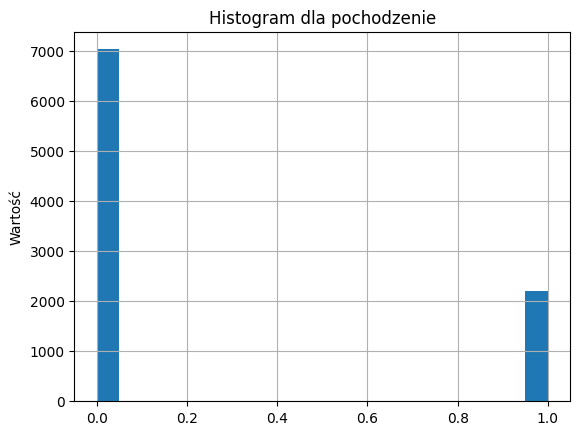

<Figure size 640x480 with 0 Axes>

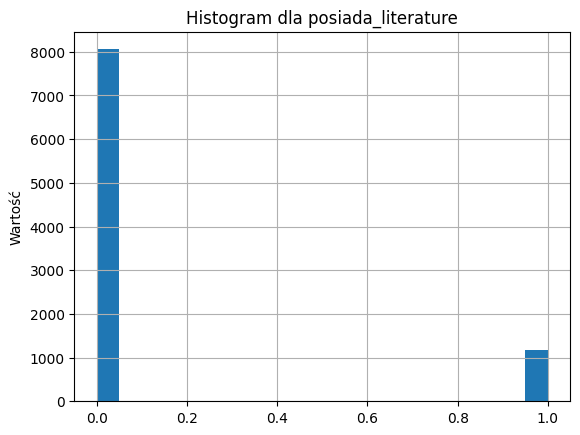

<Figure size 640x480 with 0 Axes>

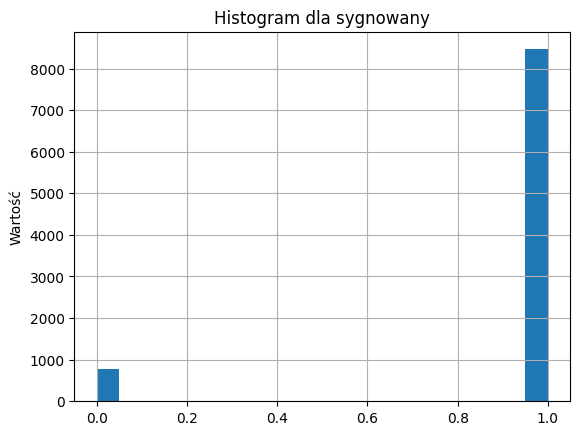

<Figure size 640x480 with 0 Axes>

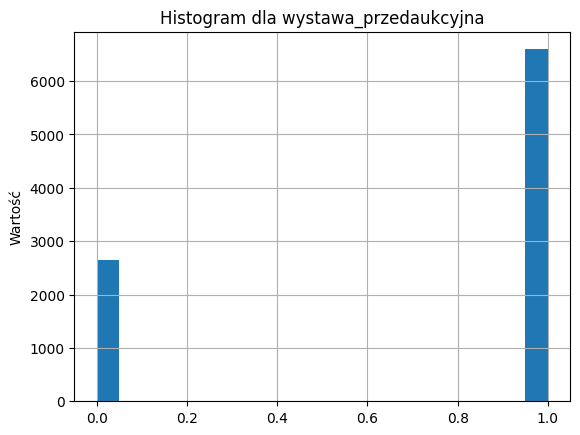

In [17]:
for column in df.select_dtypes(include='number').columns:
    plt.figure()  # Tworzy nowy wykres dla każdej zmiennej
    df.hist(column=[column], bins=20)
    plt.title(f'Histogram dla {column}')
    plt.ylabel('Wartość')
    plt.show()

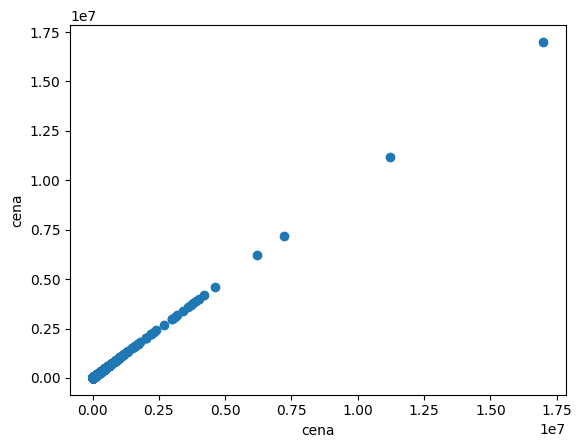

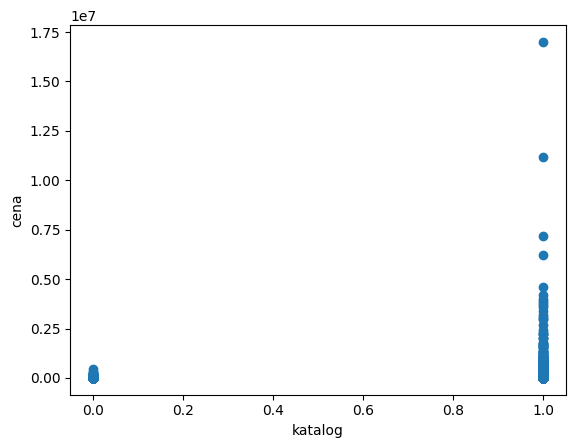

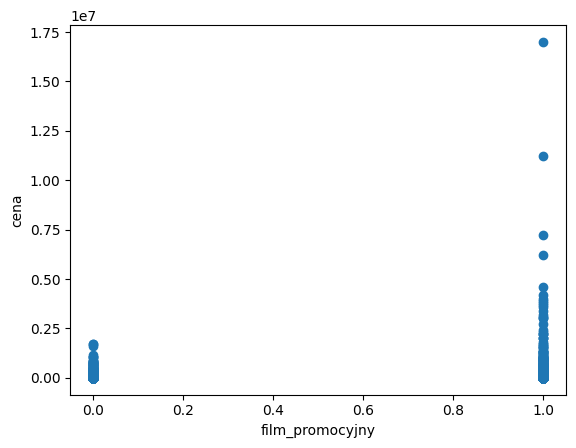

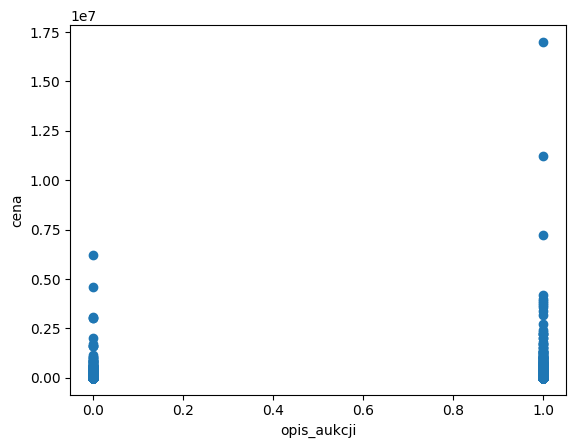

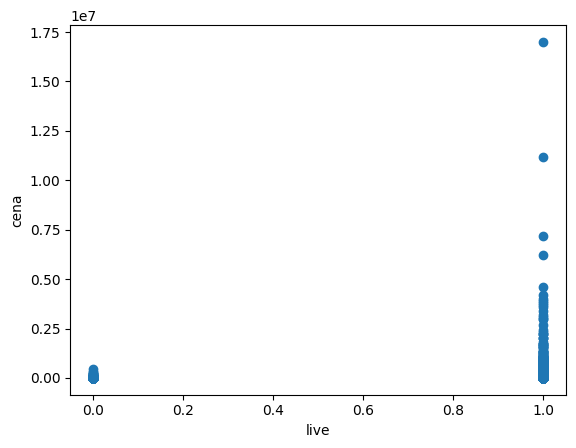

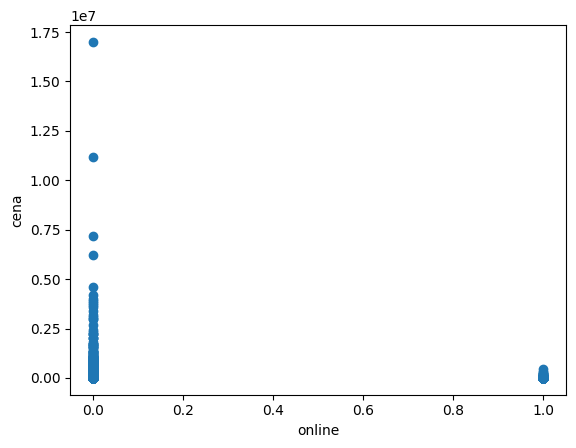

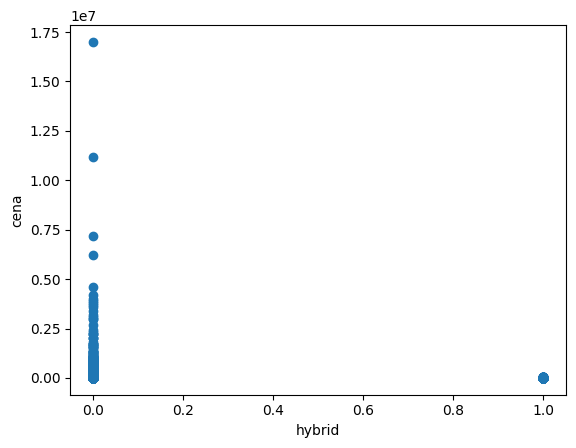

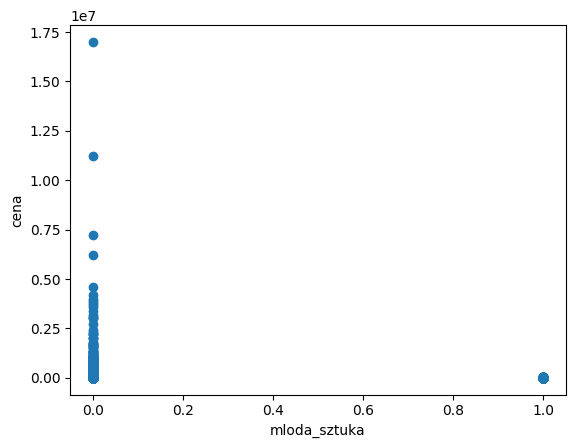

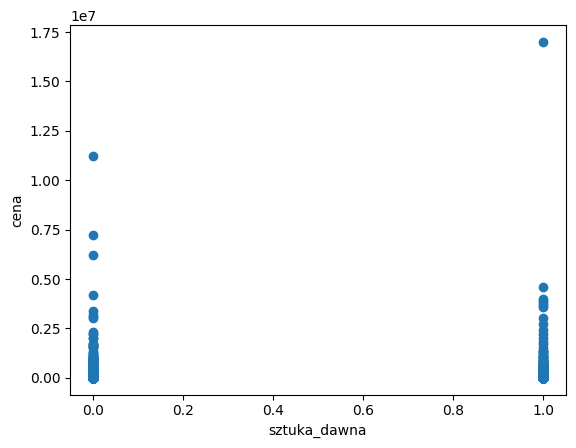

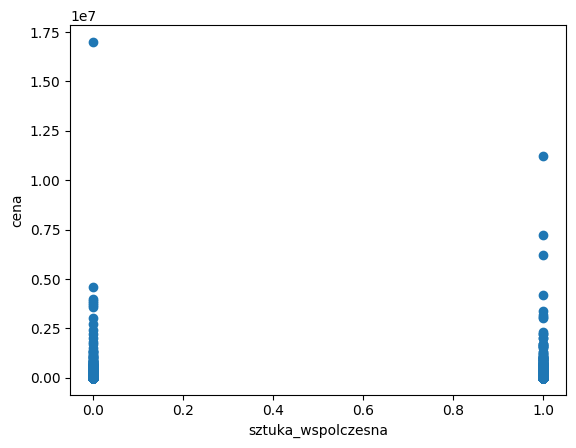

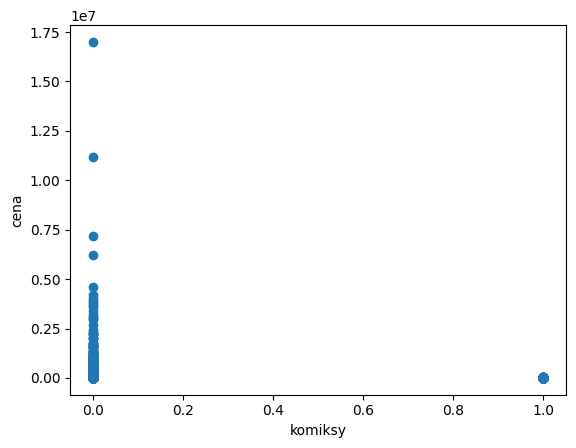

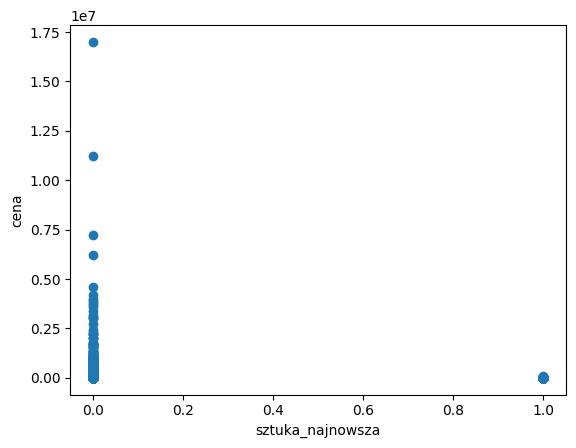

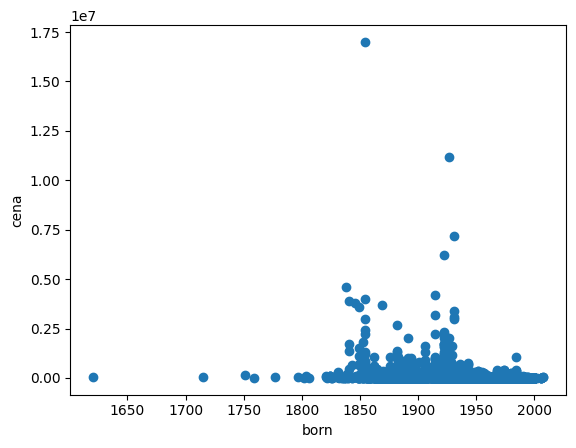

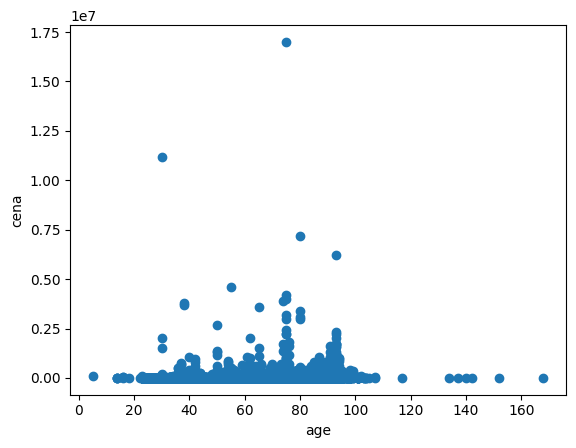

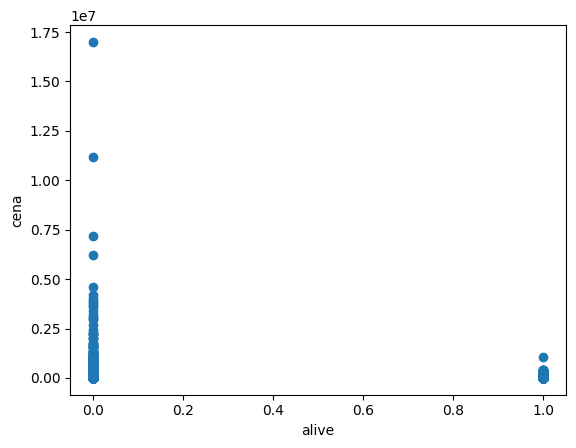

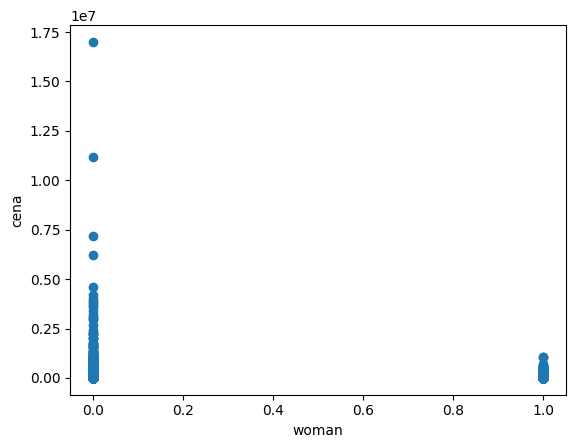

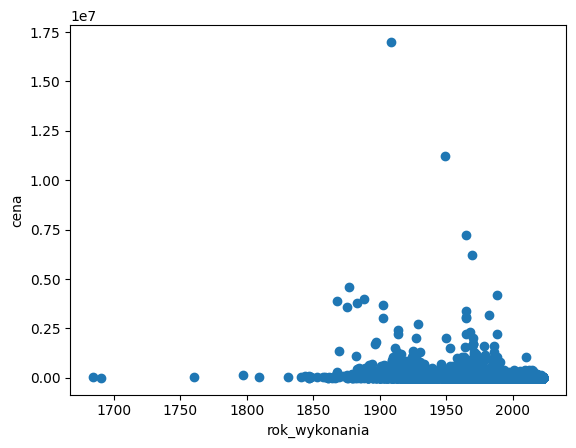

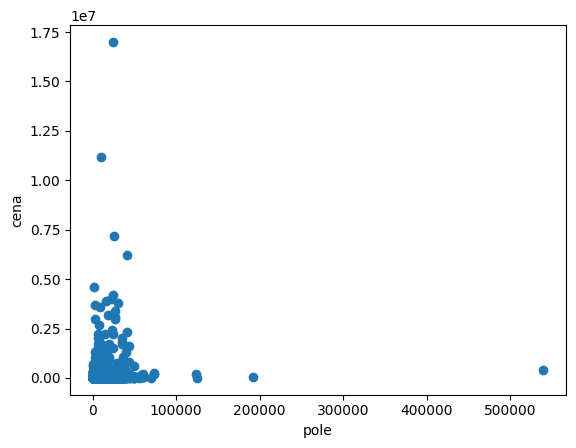

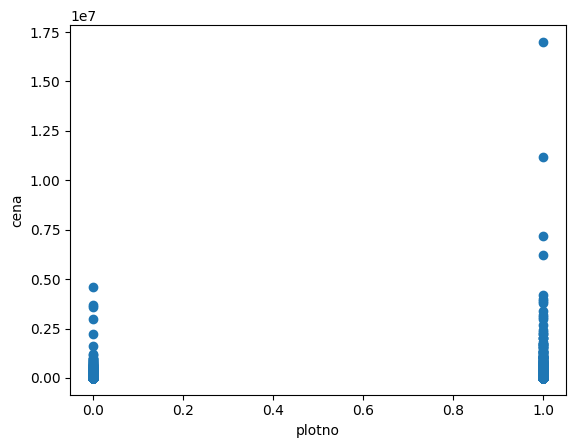

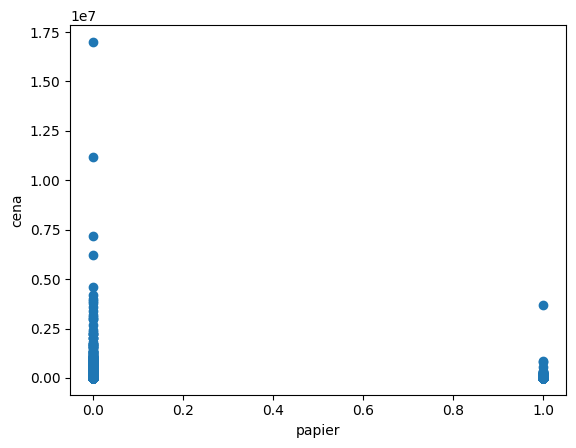

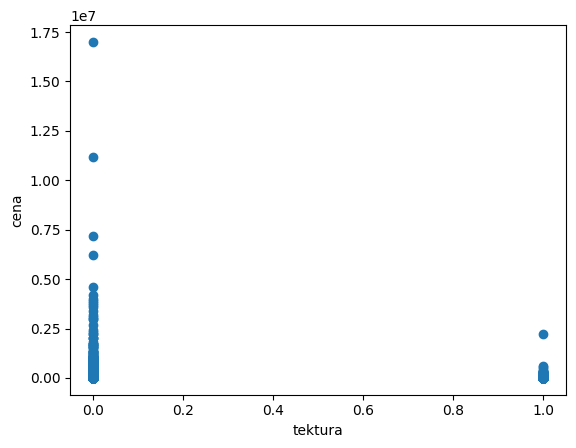

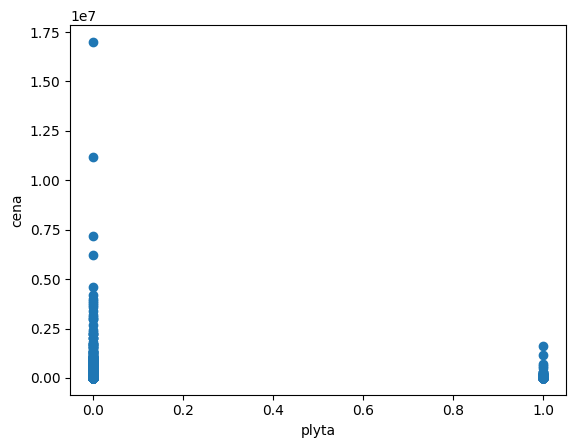

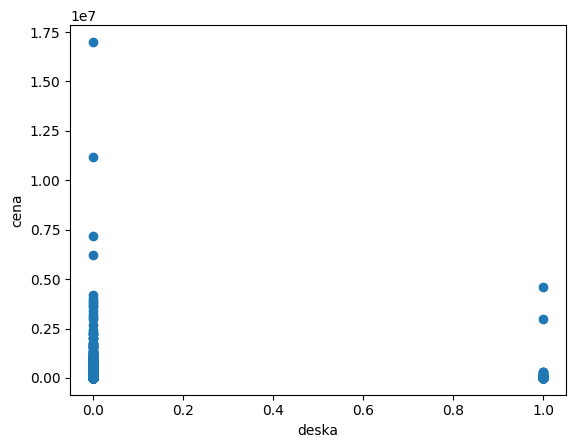

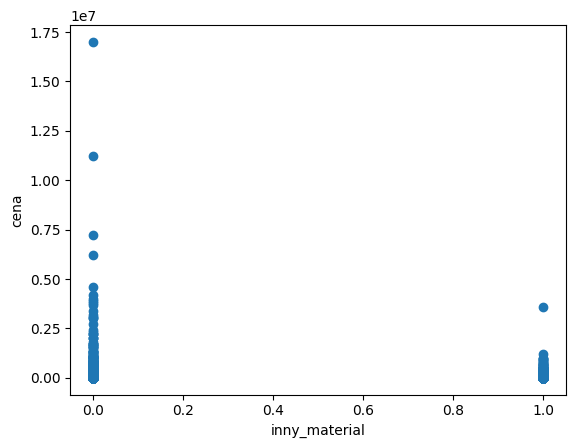

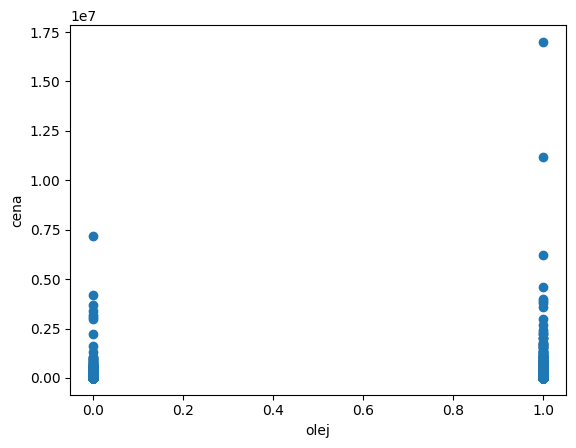

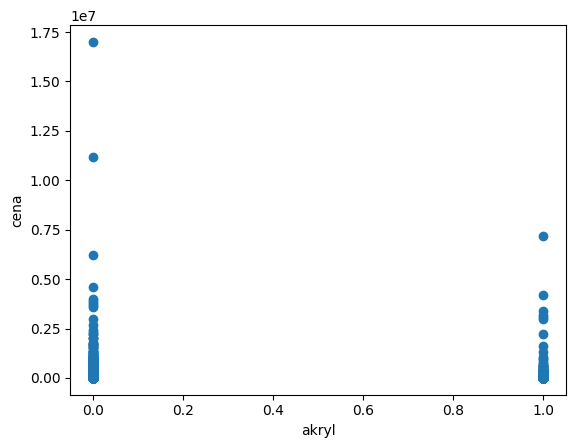

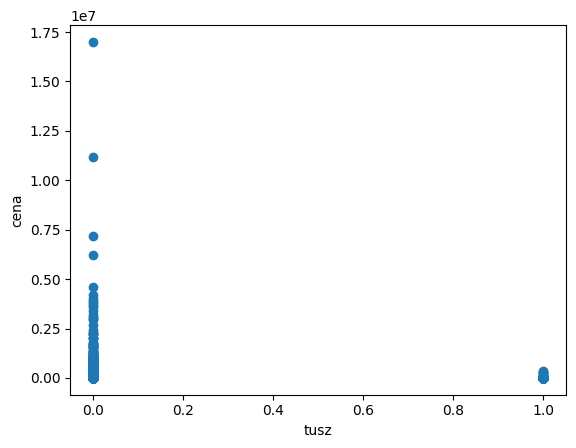

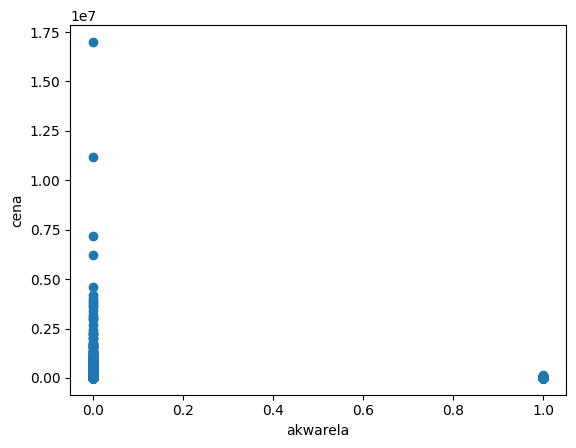

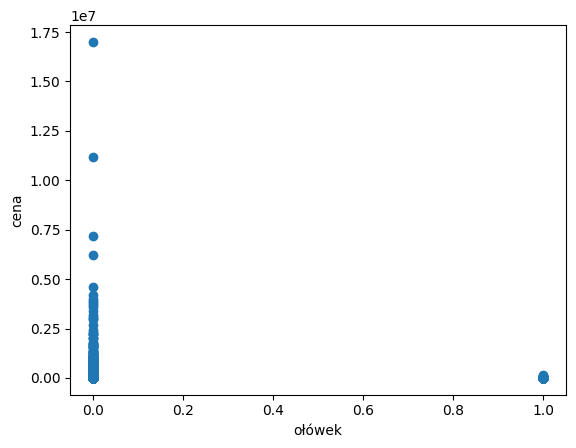

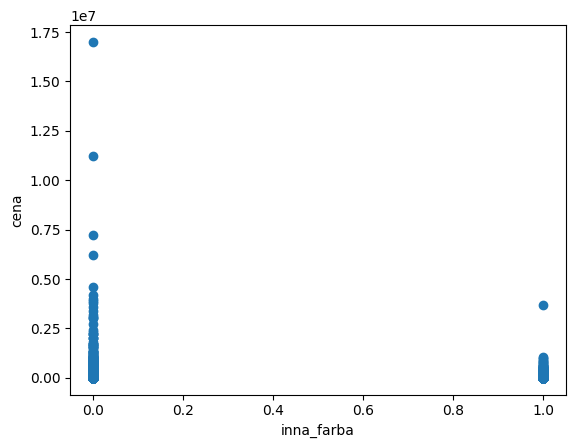

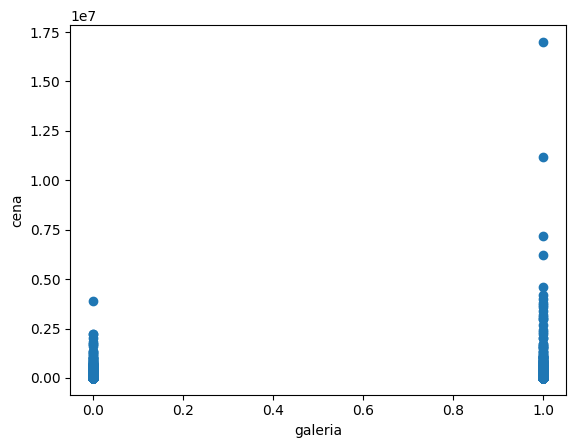

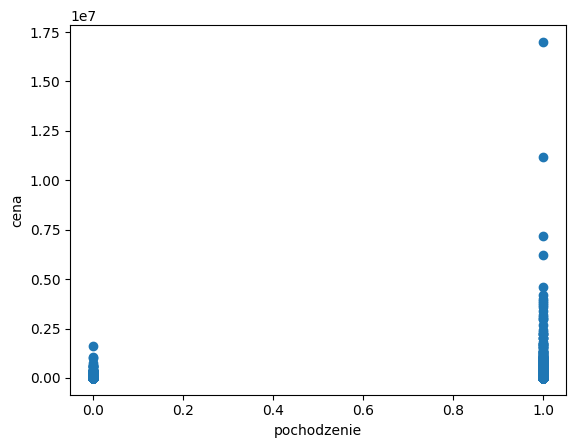

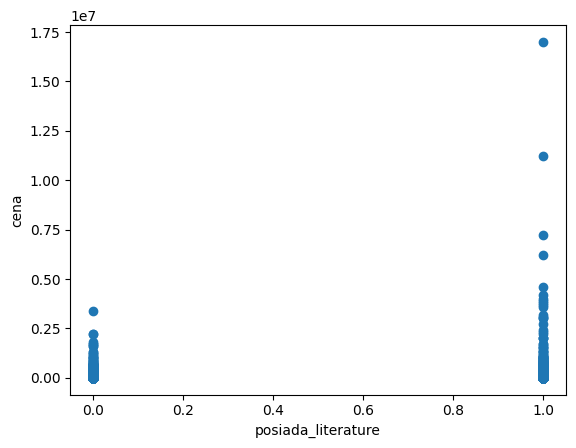

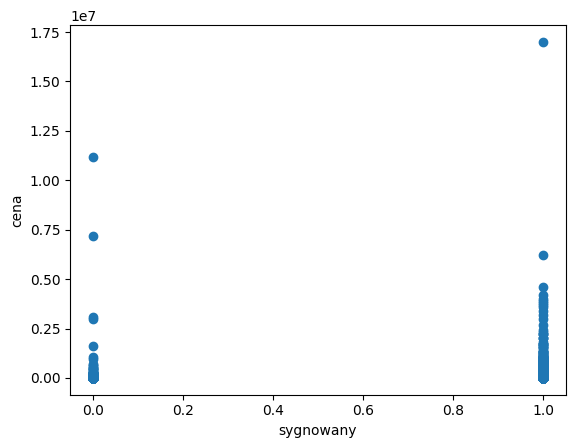

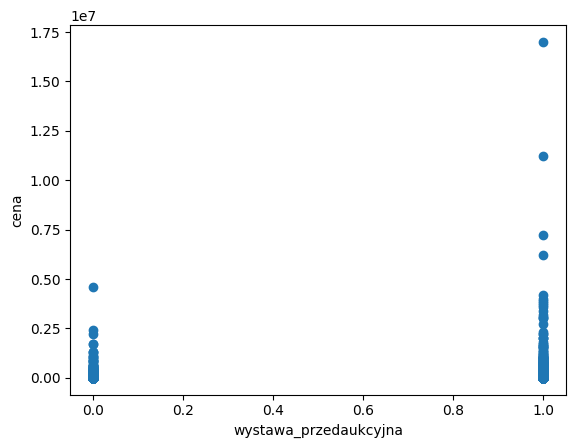

In [18]:
for i, col in enumerate(df.columns):
    plt.scatter(df[col], df['cena'])
    plt.xlabel(col)
    plt.ylabel('cena')
    plt.show()

In [18]:
#tworzenie funkcji
features = df.columns.tolist()
features.remove('cena')
wzor = 'cena ~' + '+'.join(features)

In [19]:
#MNK
m1=smf.ols(formula=wzor, data=df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cena   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     38.55
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          3.04e-210
Time:                        17:16:07   Log-Likelihood:            -1.2896e+05
No. Observations:                9233   AIC:                         2.580e+05
Df Residuals:                    9202   BIC:                         2.582e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.162e+06   2.55e+05      8.478      0.000    1.66e+06    2.66e+06
katalog               -4762.6680   1.36e+04     -0.349      0.727   -3.15e+04     2.2e+04
film_promocyjny         5.35e+04   8030.180      6.662      0.000    3.78e+04    6.92e+04
opis_aukcji            2.481e+04   7988.086      3.106      0.002    9150.406    4.05e+04
live                   7.244e+05   8.55e+04      8.476      0.000    5.57e+05    8.92e+05
online                 7.224e+05   8.53e+04      8.470      0.000    5.55e+05     8.9e+05
hybrid                 7.153e+05   8.59e+04      8.332      0.000    5.47e+05    8.84e+05
mloda_sztuka           4.998e+05   5.47e+04      9.143      0.000    3.93e+05    6.07e+05
sztuka_dawna           3.536e+05   4.31e+04      8.210      0.000    2.69e+05    4.38e+05
sztuka_wspolczesna     4.567e+05   5.31e+04      8.603      0.000    3.53e+05    5.61e+05
komiksy                4.125e+05   5.57e+04      7.409      0.000    3.03e+05    5.22e+05
sztuka_najnowsza       4.395e+05   5.59e+04      7.859      0.000     3.3e+05    5.49e+05
born                  -1483.3979    331.301     -4.477      0.000   -2132.822    -833.974
age                    -830.9549    307.040     -2.706      0.007   -1432.821    -229.089
alive                 -2.052e+04   1.15e+04     -1.789      0.074    -4.3e+04    1963.722
woman                 -5622.5412   7208.246     -0.780      0.435   -1.98e+04    8507.219
rok_wykonania          -581.0388    274.613     -2.116      0.034   -1119.341     -42.737
pole                      2.6825      0.340      7.896      0.000       2.017       3.349
plotno                 3.805e+05   4.42e+04      8.617      0.000    2.94e+05    4.67e+05
papier                 3.562e+05   4.37e+04      8.159      0.000    2.71e+05    4.42e+05
tektura                3.123e+05   4.53e+04      6.888      0.000    2.23e+05    4.01e+05
plyta                  3.718e+05   4.72e+04      7.871      0.000    2.79e+05    4.64e+05
deska                   3.91e+05   4.72e+04      8.283      0.000    2.98e+05    4.84e+05
inny_material          3.505e+05    4.4e+04      7.971      0.000    2.64e+05    4.37e+05
olej                   3.684e+05   4.34e+04      8.492      0.000    2.83e+05    4.53e+05
akryl                  3.831e+05   4.36e+04      8.781      0.000    2.98e+05    4.69e+05
tusz                   3.527e+05   4.61e+04      7.652      0.000    2.62e+05    4.43e+05
akwarela               3.394e+05   4.48e+04      7.569      0.000    2.52e+05    4.27e+05
ołówek                 3.578e+05   4.81e+04      7.439      0.000    2.64e+05    4.52e+05
inna_farba             3.607e+05   4.32e+04      8.344      0.000    2.76e+05    4.45e+05
galeria                8.828e+04   1.22e+04      7.210      0.000    6.43e+04    1.12e+05
pochodzenie            

In [151]:
target = "cena"
features = df.columns.tolist()
features.remove(target)
X_train, X_valid = train_test_split(df, test_size=0.2, random_state=100)

def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            learning_rate=0.3, max_depth=6, subsample = 1, # hiperparametry
            colsample_bytree = 1, colsample_bylevel=1, colsample_bynode=1, # hiperparametry
            reg_lambda = 1, reg_alpha=0, min_split_loss=0, max_delta_step=0, # hiperparametry
            min_child_weight=0, rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["mape"], objective = "reg:squarederror", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
   
    start_time = time.time()
    paramList= ['learning_rate', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode',
         'reg_lambda', 'reg_alpha', 'min_split_loss', 'max_delta_step', 'min_child_weight',
         'rate_drop', 'skip_drop', 'objective', 
         'eval_metric', 
         'seed', 'booster', 'tree_method', 'grow_policy'
        ,'num_boost_round', 'early_stopping_rounds'
               ]
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    
    # Przekształcenie zbiorów do struktury DMatrix
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=list(train[features].columns.values))
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=list(validate[features].columns.values))

    # Stworzenie listy zbiorów do ewaluacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, iteration_range=(0, gbm.best_iteration))
    testPred = gbm.predict(dvalid, iteration_range=(0, gbm.best_iteration))

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax, values_format='{v:.2f}', max_num_features=15)
    return score, trainPred, testPred, train_history, impFig, imp

learning_rate 0.3, max_depth 6, subsample 1, colsample_bytree 1, colsample_bylevel 1, colsample_bynode 1, reg_lambda 1, reg_alpha 0, min_split_loss 0, max_delta_step 0, min_child_weight 0, rate_drop 0.2, skip_drop 0.5, objective reg:squarederror, eval_metric ['mape'], seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 7386
Length valid: 1847
[0]	train-mape:10.70319	valid-mape:10.40565
[1]	train-mape:8.10881	valid-mape:7.99219
[2]	train-mape:6.23973	valid-mape:6.29903
[3]	train-mape:4.87740	valid-mape:5.07545
[4]	train-mape:4.00879	valid-mape:4.26029
[5]	train-mape:3.39292	valid-mape:3.71519
[6]	train-mape:2.89250	valid-mape:3.25373
[7]	train-mape:2.52641	valid-mape:2.98279
[8]	train-mape:2.25258	valid-mape:2.77857
[9]	train-mape:2.14017	valid-mape:2.67665
[10]	train-mape:1.98544	valid-mape:2.59728
[11]	train-mape:1.93006	valid-mape:2.62271
[12]	train-mape:1.82310	valid-mape:2.52162
[13]	train-mape:1.82675	valid-mape:2.50019
[14]	train-mape:1.83254	valid

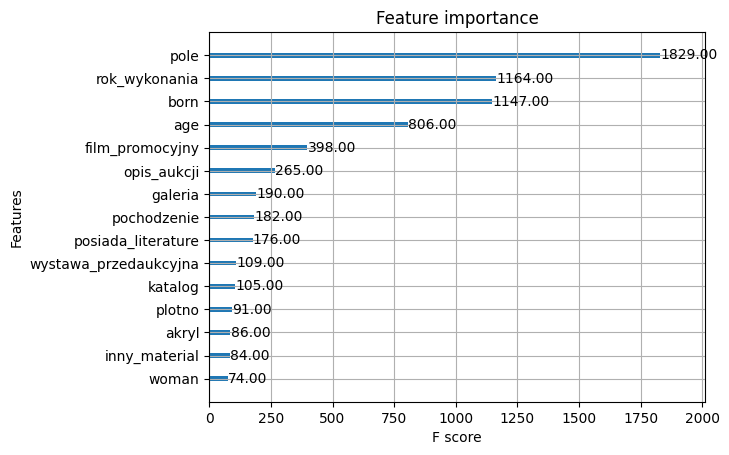

In [117]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

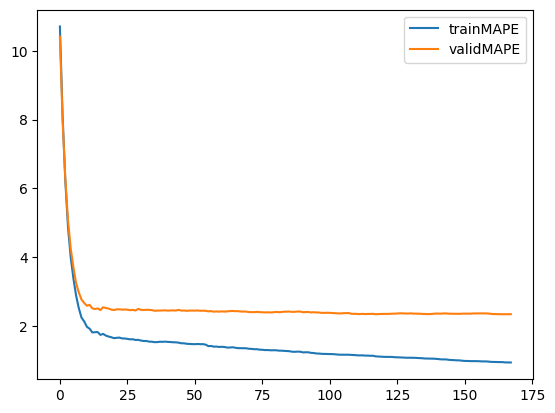

In [118]:
train_history.plot()
plt.show()

2 4.08584766140844
4 2.689119397248918
6 2.3501897287824267
8 2.199910462326743
10 2.0019811484391576
12 2.0750013866959303
14 1.9300323944776034
16 1.9562272094460833
18 1.9008677085310308
20 1.9143961685332802
22 1.9175092680159893
24 1.9297762768978628
26 1.9322000954433283
28 1.9286319879921123


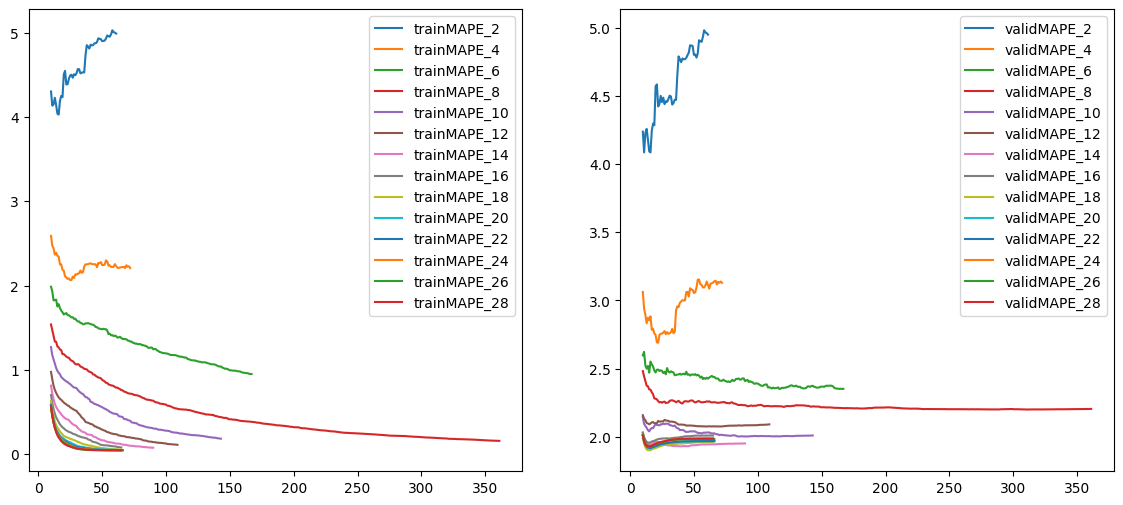

In [147]:
# Sprawdzenie modelu dla różnych wartości max_depth:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(2,30,2)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0.3 2.684977354856022
0.4 2.999272766473648
0.5 2.6343901396269915
0.6 2.5943606724273223
0.7 2.595406045942957
0.8 2.4087751644871775
0.9 2.5230861407977945
1.0 2.199910462326743


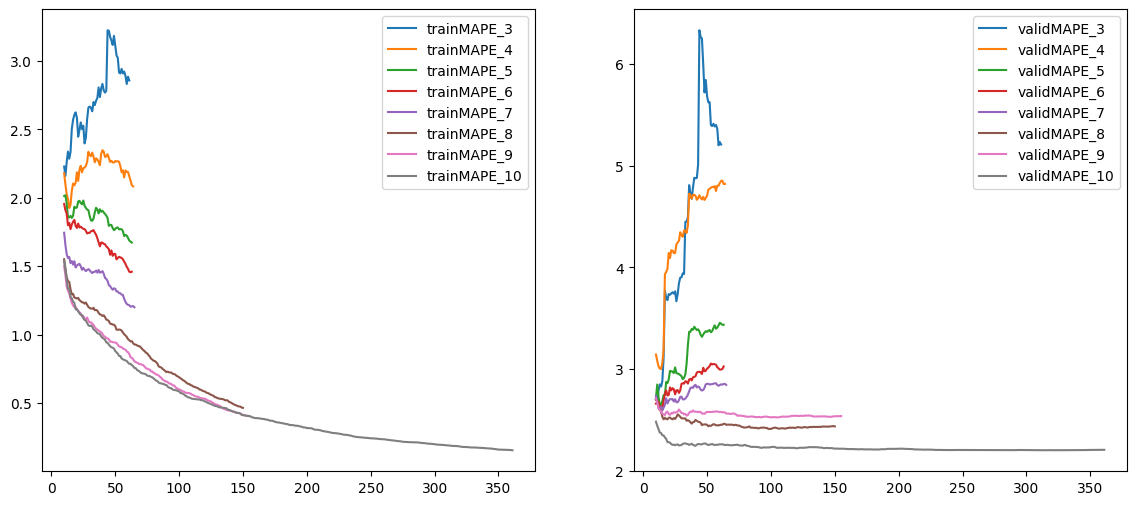

In [124]:
# Sprawdzenie modelu dla różnych wartości subsample:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=18, subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0.3 2.190393442195703
0.4 2.2794564364896
0.5 2.0087268559202154
0.6 2.1390732800878167
0.7 1.9291993119718853
0.8 2.0092676751449754
0.9 1.8773850096439382
1.0 2.199910462326743


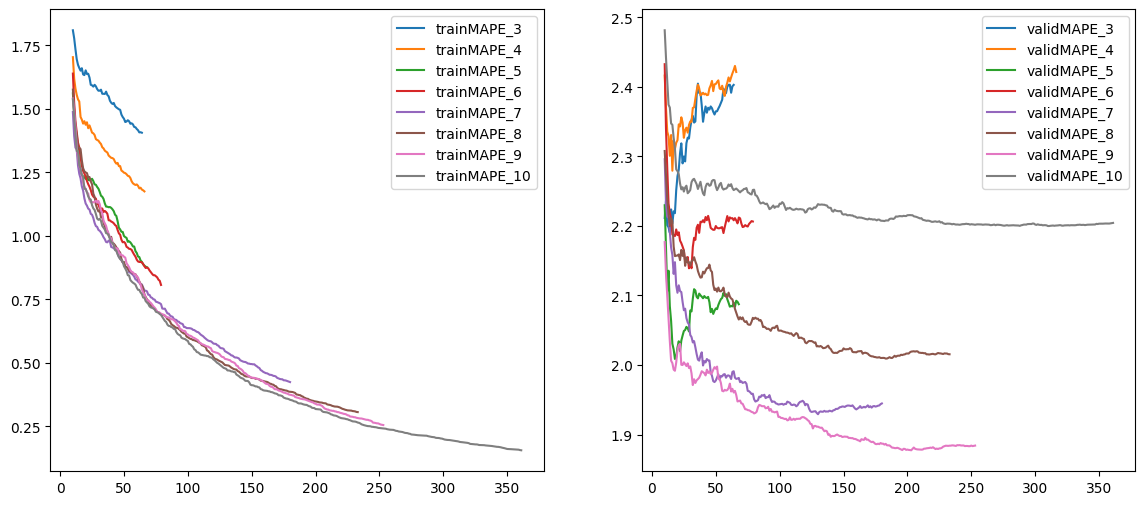

In [126]:
# Sprawdzenie modelu dla różnych wartości colsample_bytree:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8, subsample=1, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

500 1.8973471591130675
550 1.8639851119187587
600 1.8421409109455564
650 1.8574187629269365
700 1.8078370903604515
750 1.871949071218511
800 1.8581311217369978
850 1.8378917133778738
900 1.8203732888488469
950 1.84265591426572


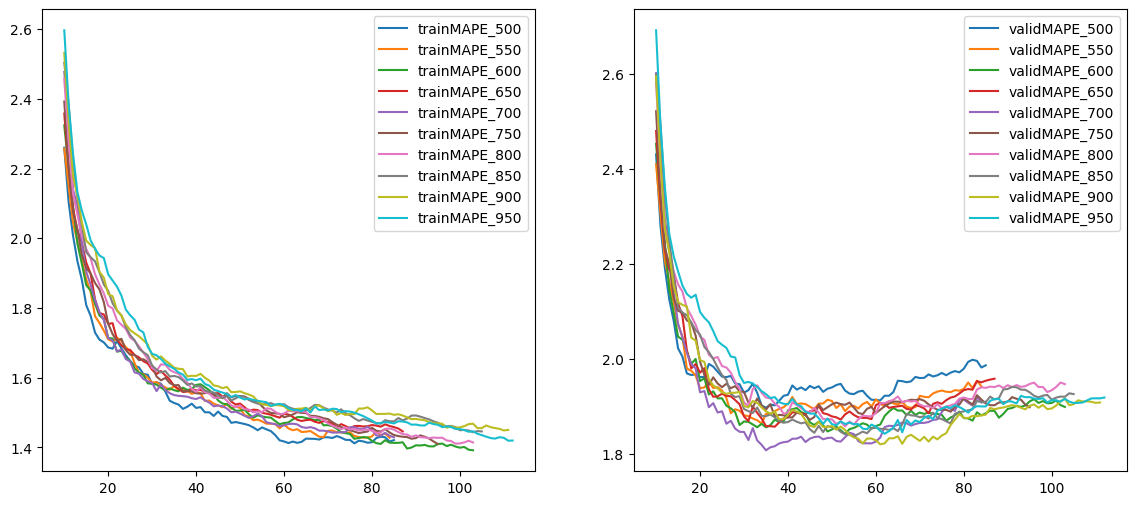

In [133]:
# Sprawdzenie modelu dla różnych wartości reg_lambda:
resHists = dict()
rang = range(500,1000,50)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8, subsample=1, colsample_bytree=0.9, reg_lambda=x,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0 1.8078370903604515
1 1.8078370903604515
4 1.8078370903604515
9 1.8078370903604515
16 1.8078370903604515
25 1.8078370903604515
36 1.8078370903604515
49 1.8078370903604515
64 1.8078370903604515
81 1.8078370903604515
100 1.8078370903604515


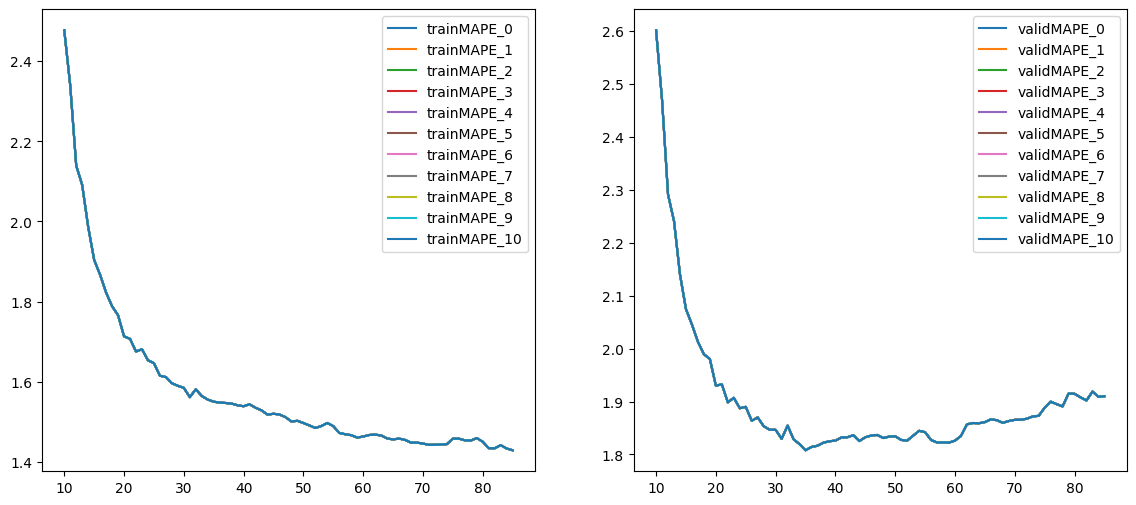

In [135]:
# Sprawdzenie modelu dla różnych wartości min_split_loss (gamma):
resHists = dict()
rang = range(0,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, 
                                                          max_depth=8, subsample=1, colsample_bytree=0.9, reg_lambda=700, min_split_loss=x**2,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x**2, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

1 1.882782854790881
11 1.833468292522551
21 1.8041395950769605
31 1.8503362626185027
41 1.876343395794756
51 1.9023057877893637
61 1.8567928121555115
71 1.9085626467879804
81 1.9449146746790906
91 1.956511962346712


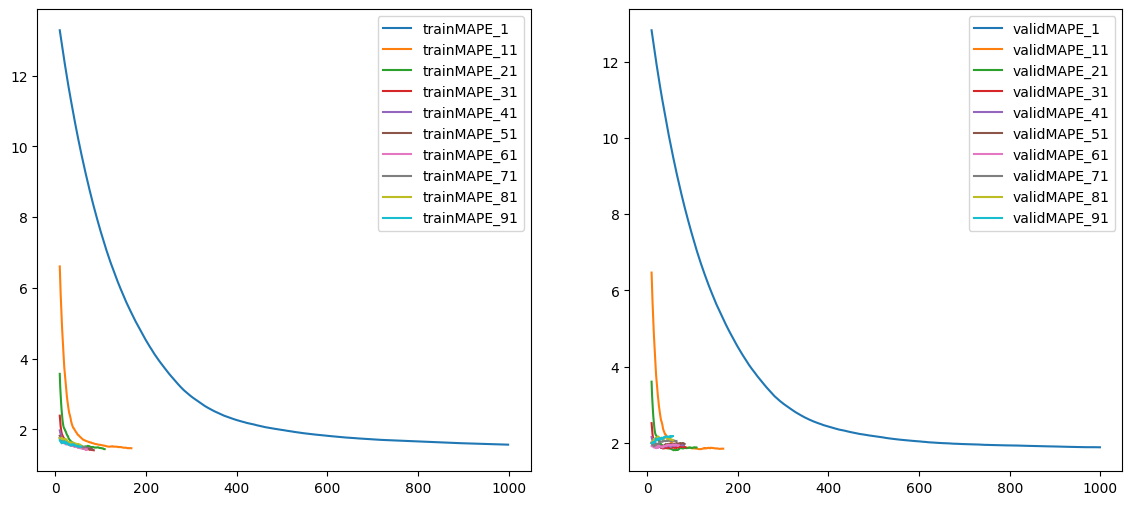

In [140]:

# Sprawdzenie modelu dla różnych wartości learning rate:
resHists = dict()
rang = range(1,101,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, 
                                                          max_depth=8, subsample=1, colsample_bytree=0.9, reg_lambda=700, learning_rate=x/100,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validMAPE']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

In [200]:
# Wrapper do walidacji krzyżowej
def CVTestXGB(nFolds = 5, randomState=2017, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    Results = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, early_stopping_rounds=50, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        testScore = score
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Average score:", testScore)
        
    return testResults, predictions, indices, pd.concat(hists, axis=1)

In [201]:
testResults, predictions, indices, hists = CVTestXGB(
    max_depth=8, subsample=1, colsample_bytree=0.9, reg_lambda=700, learning_rate=0.2)
np.mean(testResults)

2.801791021875193

1 2.8020199253147857
11 2.796709312376427
21 2.7912153379818103
31 2.7862490805834828
41 2.781675418733538
51 2.777856820985586
61 2.7746617572714842
71 2.771813464455989
81 2.770067919509297
91 2.767990406753727


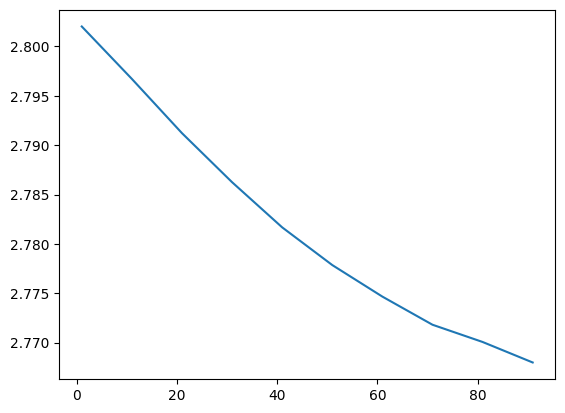

In [163]:
rang = range(1,101,10)
results = []
for x in rang:
    testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, learning_rate=x/100)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

In [168]:
#Random search
results=[]
paramList = []
for x in range(100):
    params = (randint(3, 9), uniform(0.1, 0.9), uniform(0.1, 0.9), uniform(0, 10), uniform(0, 10))
    testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        reg_lambda=params[3],
        min_split_loss=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)

2.7728338205882284 (5, 0.5613684419672235, 0.7362632168835599, 6.303248709214061, 3.567566698105119)
2.7763787009652208 (8, 0.14808800126234198, 0.21997530875619262, 9.431319867456363, 3.424547347660807)
2.7756663944247135 (5, 0.8381735599037309, 0.34659880078773264, 9.396867628358153, 4.9215122732455)
2.7759914055608834 (5, 0.32375006146202445, 0.3213248195109698, 8.766958294880013, 9.229551135672128)
2.7734017931981545 (6, 0.44028824087900764, 0.8380981858645346, 4.249961528668368, 0.3952190260823796)
2.7762903730287563 (3, 0.48701707497622115, 0.7729909277111646, 6.927418254849968, 1.0221964669076689)
2.7790992316756573 (5, 0.8826067117761286, 0.244354062039704, 5.153484938731544, 8.881314008301034)
2.7780019104090545 (4, 0.813214070484213, 0.5979089880644664, 7.038891995711452, 7.683820104528243)
2.7744862099420713 (6, 0.38661672617943776, 0.734013344097564, 8.241354621505142, 0.5491531853365095)
2.7836573787431327 (3, 0.26337528169546653, 0.263472541544005, 0.25052624929866485, 5.

In [180]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(min(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(2.8674964954340267, (4, 0.2766535040246795, 0.16219711931816008, 9.374999263277507, 7.89451046795835))
(2.8641253844792502, (9, 0.6092603393806062, 0.7946024812319049, 3.1706761197873004, 0.22969233660184996))
(2.8626872587292236, (8, 0.26689511780120223, 0.22591585268509906, 0.8637036599372938, 5.7034877350932165))
(2.861385425488351, (9, 0.5888157385819621, 0.5103830916849953, 1.7648221371032458, 6.297216350002274))
(2.8602621967330792, (4, 0.44168221876529257, 0.45851830467811083, 1.327087073558978, 8.03850761044401))
(2.859991431331643, (5, 0.6211225176278495, 0.16985290372032547, 7.573603506137781, 0.581174302117391))
(2.859835421658889, (6, 0.112682301262881, 0.7712881150761797, 1.4374804680234976, 0.2306523229058155))
(2.859799436516872, (5, 0.6261604059004277, 0.25241810716692425, 4.584736483467518, 3.9041944223961442))
(2.8594727686783923, (6, 0.3517615500886079, 0.4968140404974618, 9.5729294551947, 4.652217632319116))
(2.8589516920469378, (3, 0.2764644214991824, 0.7272217853